# Metalayer in a transductive setting for Edge betweenness
This notebook shows how a MetaLayer(MPNN) model is trained to compute Ege betweenness on Cora graph

## 1. Edge betweenness training

In [163]:
from __future__ import division

%load_ext autoreload
%autoreload 2


import time
from pprint import pprint
import torch
from torch.nn import *
import os.path as osp
import importlib

import torch
from torch import tensor
from torch.optim import Adam
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_mean

import torch_geometric.transforms as T
from torch_geometric.nn import SGConv, APPNP, ChebConv, GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
#from torch_geometric.nn import LinkGCNConv
from torch_geometric.nn import SAGEConv
from torch_geometric.data import DataLoader
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from torch_geometric.nn import MetaLayer

from TFM_edge_betweenness_model import META1
from TFM_node_betweenness_training import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
def dataset_preprocessing(data, thebins=None, num_features=1):
    # get dataset, see data.y is classess
    data
    #data.y

    # transform to nx
    #g = pyTorchGeometricDatasetToNx(data)
    g = pytorch_geometric_dataset_to_Nx2(data)

    # compute node betweenness
    eb = nx.edge_betweenness_centrality(g,normalized=True)
    
    # generate edge_target_attr's from eb dict
    data.edge_attr = torch.zeros(len(data.edge_index[0]),1)
    data.y = torch.ones(len(data.edge_index[0]),1)
    for j in range(len(data.edge_index[0])):
        t = (data.edge_index[0][j].item(), data.edge_index[1][j].item()) 
        t2 = (data.edge_index[1][j].item(), data.edge_index[0][j].item())

        if t in eb.keys():
            #print(t, eb[t])
            data.y[j]=eb[t]

        elif t2 in eb.keys():
            #print(t2, eb[t2])
            data.y[j]=eb[t2]
        else:
            # if edge was redundant it may not be captured by nx
            # but since it appeared in the original dataset we add it with value 0
            eb[t]=0.0
            #print(t, eb[t])
            data.y[j]=eb[t]

        #print(t,t2,data.edge_attr[j])
        #print(data.y[j])
        #print()

    data.y = data.y.reshape(-1,1)
    data.x = data.x.reshape(-1,1)
    data.y = data.y.float()
    data.y = torch.FloatTensor(data.y)
    data.edge_attr = data.edge_attr.float()
    
    # auto-iteration would be great...
    if thebins is None:
        thebins= [0.0, 1e-10000000, 2e-7, 2e-4,5e-4, 7e-4, 15e-4, ]
        
    bins = np.array(thebins)
    y_discrete= np.digitize(data.y.numpy(), bins)
    print(y_discrete)
    plt.hist(y_discrete)
    
    # discretize target edge_betweenness
    y_discrete = y_discrete.flatten()
    
    y_list = y_discrete.tolist()
    for j in range(len(y_list)):
        if y_list[j] == 3:
            y_list[j]=0
        elif y_list[j] == 4:
            y_list[j]=1
        elif y_list[j] == 5:
            y_list[j]=2
        elif y_list[j] == 6:
            y_list[j]=3
        elif y_list[j] == 7:
            y_list[j]=4
        elif y_list[j] == 8:
            y_list[j]=5

    y_discrete = np.array(y_list)
    all_classes = list(set(list(y_discrete.tolist())))
    print("num_classes=",len(all_classes),"\n",all_classes)
    
    num_features = num_features
    num_classes = len(all_classes)
    num_edges = len(data.edge_index[0])
    num_edge_features = 1
    
    data.undiscretize = thebins[1:-1]
    
    return data, torch.LongTensor(y_discrete), num_features, num_classes, num_edges, num_edge_features

    

In [195]:

def get_planetoid_dataset(root,name, normalize_features=False, transform=None):
    #path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', name)
    dataset = Planetoid(root, name)

    if transform is not None and normalize_features:
        dataset.transform = T.Compose([T.NormalizeFeatures(), transform])
    elif normalize_features:
        dataset.transform = T.NormalizeFeatures()
    elif transform is not None:
        dataset.transform = transform

    return dataset



In [196]:
def scatter_plot(preds, targets, 
                 filename='scatterplot.png', 
                 name='scatterplot', 
                 continuous_targets=None,
                 continuous_bins=None,
                 model_id=''):
    newy = np.array(preds.cpu())
    newt = np.array(targets.cpu())
    
    plt.plot(newt, newy,'o', color='black')
    plt.xlabel('target')
    plt.ylabel('prediction');
    plt.plot(newt, newt, color = 'red', linewidth = 2)
    # ranges
    #ax.xlim(0, 1)
    #ax.ylim(0, 1)
    # title
    plt.title(name)
    datetime_str =  datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
    plt.savefig(datetime_str+'_'+model_id+'_'+filename)
    plt.show()
    
    if continuous_targets is not None and continuous_bins is not None:
        newt = np.array(continuous_targets)
        # translate newy
        newy2 = newy.flatten().tolist()
        for jj in range(len(newy)):
            newy2[jj] = continuous_bins[int(newy2[jj])]
        newy2 = np.array(newy2)
        
        plt.plot(newt, newy2,'o', color='black')
        plt.xlabel('target')
        plt.ylabel('prediction');
        plt.plot(newt, newt, color = 'red', linewidth = 2)
        # ranges
        #ax.xlim(0, 1)
        #ax.ylim(0, 1)
        # title
        plt.title(name)
        datetime_str =  datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
        plt.savefig(datetime_str+'_'+model_id+'_'+filename.replace('.png','_real_eb.png'))
        plt.show()
    
def histogram_plot(preds, targets, 
                   filename='histogram.png', 
                   name='histogram', 
                   continuous_targets=None,
                   continuous_bins=None,
                   model_id=''):
    newy = np.array(preds.cpu())
    newt = np.array(targets.cpu())
    
    
    plt.hist(newy, density=True,alpha=0.6, label='prediction')
    plt.hist(newt, density=True, alpha=0.6, label='target')
    # ranges
    #ax.xlim(0, 1)
    #ax.ylim(0, 1)
    # title
    plt.xlabel('classes')
    plt.ylabel('density')
    plt.title(name)
    datetime_str =  datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
    plt.legend(prop={'size': 10})
    plt.savefig(datetime_str+'_'+model_id+'_'+filename)
    plt.show()
    
    if continuous_targets is not None and continuous_bins is not None:
        newt = np.array(continuous_targets)
        # translate newy
        newy2 = newy.flatten().tolist()
        for jj in range(len(newy)):
            newy2[jj] = continuous_bins[int(newy2[jj])]
        newy2 = np.array(newy2)
        
            
        plt.hist(newy2, density=True,alpha=0.6, label='prediction')
        plt.hist(newt, density=True, alpha=0.6, label='target')
        # ranges
        #ax.xlim(0, 1)
        #ax.ylim(0, 1)
        # title
        plt.xlabel('classes')
        plt.ylabel('counts')
        plt.title(name)
        datetime_str =  datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
        plt.legend(prop={'size': 10})
        plt.savefig(datetime_str+'_'+model_id+'_'+filename.replace('.png','_real_eb.png'))
        plt.show()
    
def boxplot_plot(preds, targets, 
                 filename='boxplot.png', 
                 name='boxplot', 
                 continuous_targets=None,
                 continuous_bins=None,
                 model_id=''):

    newy = np.array(preds.cpu())
    newt = np.array(targets.cpu())
        
    newy.shape=newt.shape
    plt.boxplot([newt,newy], labels=['target','pred'])
    plt.title(name)
    datetime_str =  datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
    plt.savefig(datetime_str+'_'+model_id+'_'+filename)
    plt.show()
    
    if continuous_targets is not None and continuous_bins is not None:
        newt = np.array(continuous_targets)
        # translate newy
        newy2 = newy.flatten().tolist()
        for jj in range(len(newy)):
            newy2[jj] = continuous_bins[int(newy2[jj])]
        newy2 = np.array(newy2)
        
        newt.shape=newy2.shape
        plt.boxplot([newt,newy2], labels=['target','pred'])
        plt.title(name)
        datetime_str =  datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
        plt.savefig(datetime_str+'_'+model_id+'_'+filename.replace('.png','_real_eb.png'))
        plt.show()

def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.uint8, device=index.device)
    mask[index] = 1
    return mask


def random_planetoid_splits(data, y, num_classes, tr_split=20, val_split=500, test_split=1500):
    # Set new random planetoid splits:
    # * 20 * num_classes labels for training
    # * 500 labels for validation
    # * 1000 labels for testing
    

    #indices = []
    #for i in range(num_classes):
    #    index = (data.y == i).nonzero().view(-1)
    #    index = index[torch.randperm(index.size(0))]
    #    indices.append(index)
    ## changed 20 -> 40, 500->750 
    #train_index = torch.cat([i[:tr_split] for i in indices], dim=0)

    #rest_index = torch.cat([i[tr_split:] for i in indices], dim=0)
    #rest_index = rest_index[torch.randperm(rest_index.size(0))]

    #data.train_mask = index_to_mask(train_index, size=data.num_nodes)
    #data.val_mask = index_to_mask(rest_index[:val_split], size=data.num_nodes)
    #data.test_mask = index_to_mask(rest_index[val_split:test_split], size=data.num_nodes)
    
    # they should be correspondent, so train_edge_mask & co should be derived...
    # too lazy , just remove mask for nodes for now
    
    indices = []
    for i in range(num_classes):
        index = (y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)
    # changed 20 -> 40, 500->750 
    train_index = torch.cat([i[:tr_split] for i in indices], dim=0)

    rest_index = torch.cat([i[tr_split:] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]
    
    data.train_edge_mask = index_to_mask(train_index, size=len(y))
    data.val_edge_mask = index_to_mask(rest_index[:val_split], size=len(y))
    data.test_edge_mask = index_to_mask(rest_index[val_split:test_split], size=len(y))

    return data


def train(model, optimizer, data, y):
    model.train()
    optimizer.zero_grad()
    # so the model uses all the nodes and edges
    out = model(data)
    # but only tests loss on masked edges...
    loss = F.nll_loss(out[data.train_edge_mask], y[data.train_edge_mask])
    loss.backward()
    optimizer.step()


def evaluate(model, data, y, plots=False, continuous_targets=None,continuous_bins=None,model_id='model'):
    model.eval()

    with torch.no_grad():
        logits = model(data)

    outs = {}
    for key in ['train', 'val', 'test']:
        mask = data['{}_mask'.format(key)]
        edge_mask = data['{}_edge_mask'.format(key)]
        loss = F.nll_loss(logits[edge_mask], y[edge_mask]).item()
        pred = logits[edge_mask].max(1)[1]
        acc = pred.eq(y[edge_mask]).sum().item() / edge_mask.sum().item()

        if plots:
            # scatter plot
            scatter_plot(pred,y[edge_mask], continuous_targets=continuous_targets[edge_mask], continuous_bins=continuous_bins,model_id=model_id)
            
            # histogram
            histogram_plot(pred,y[edge_mask], continuous_targets=continuous_targets[edge_mask], continuous_bins=continuous_bins,model_id=model_id)
            
            # boxplot
            boxplot_plot(pred,y[edge_mask], continuous_targets=continuous_targets[edge_mask], continuous_bins=continuous_bins,model_id=model_id)
            
        outs['{}_loss'.format(key)] = loss
        outs['{}_acc'.format(key)] = acc

    return outs




def run(dataset,
        y,
        num_classes,
        model,
        runs,
        epochs,
        lr,
        weight_decay,
        early_stopping,
        permute_masks=None,
        tr_mask_length=20, val_mask_length=500, test_mask_length=1500,
        logger=None,
        results_file='GN_exp1_semisuperv.csv',
        continuous_targets=None,
        continuous_bins=None):
    
    print("RUn ",str(model))
    model_params= str(model)+'_r='+str(runs)+'_epochs='+str(epochs)+'_split-'+str(tr_mask_length)+'-'+str(val_mask_length)+'-'+str(test_mask_length)+'-'
    model_id = str(model.__class__.__name__)+model_params

    val_losses, accs, durations = [], [], []
    for _ in range(runs):
        data = dataset[0]
        if permute_masks is not None:
            data = permute_masks(data,y, num_classes,
                                 tr_split=tr_mask_length,
                                 val_split=val_mask_length, 
                                 test_split=test_mask_length)
        data = data.to(device)
        y = y.to(device)

        model.to(device).reset_parameters()
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_start = time.perf_counter()

        best_val_loss = float('inf')
        test_acc = 0
        val_loss_history = []

        for epoch in range(1, epochs + 1):
            train(model, optimizer, data, y)
            eval_info = evaluate(model, data, y)
            eval_info['epoch'] = epoch

            if logger is not None:
                logger(eval_info)

            if eval_info['val_loss'] < best_val_loss:
                best_val_loss = eval_info['val_loss']
                test_acc = eval_info['test_acc']

            val_loss_history.append(eval_info['val_loss'])
            if early_stopping > 0 and epoch > epochs // 2:
                tmp = tensor(val_loss_history[-(early_stopping + 1):-1])
                if eval_info['val_loss'] > tmp.mean().item():
                    if _ == runs-1:
                        eval_info = evaluate(
                            model, 
                            data, 
                            y, 
                            plots=True, 
                            continuous_targets=continuous_targets,
                            continuous_bins=continuous_bins,
                            model_id=model_id,
                        )
                    break

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()

        val_losses.append(best_val_loss)
        accs.append(test_acc)
        durations.append(t_end - t_start)
        
        
            
        
        

    loss, acc, duration = tensor(val_losses), tensor(accs), tensor(durations)

    print('Val Loss: {:.4f}, Test Accuracy: {:.3f} ± {:.3f}, Duration: {:.3f}'.
          format(loss.mean().item(),
                 acc.mean().item(),
                 acc.std().item(),
                 duration.mean().item()))
    with open(results_file,'a') as f:
        f.write('{}, {}, {:.4f}, {:.3f} ± {:.3f}, {:.3f}\n'.
          format(
                 model.__class__.__name__, 
                 model_params,
                 loss.mean().item(),
                 acc.mean().item(),
                 acc.std().item(),
                 duration.mean().item()))
            

In [197]:
class EdgeModel(torch.nn.Module):
    def __init__(self,num_edge_features, num_features, num_edges, hidden_units=10,out_units=10):
        super(EdgeModel, self).__init__()
        #self.edge_mlp = Seq(Lin(2 * 10 + 5 + 20, 5), ReLU(), Lin(5, 5))
        self.edge_mlp = Seq(
            Lin(2*num_features + num_edge_features +1 ,hidden_units), 
            ReLU(), 
            Lin(hidden_units, out_units))

    def forward(self, src, dest, edge_attr, u, batch):
        # source, target: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        #print(src.shape, dest.shape, edge_attr.shape, u[batch].shape)
        out = torch.cat([src, dest, edge_attr, u[batch]], 1)
        return self.edge_mlp(out)

class NodeModel(torch.nn.Module):
    def __init__(self,
                 num_edge_features, num_features, num_edges,
                 hidden_units=10,out_units_edge=10, 
                 out_units_node1=10, out_units_node2=10):  
        super(NodeModel, self).__init__()
        #self.node_mlp_1 = Seq(Lin(15, 10), ReLU(), Lin(10, 10))
        
        self.node_mlp_1 = Seq(
            Lin(num_features+out_units_edge, hidden_units), 
            ReLU(), 
            Lin(hidden_units, out_units_node1))
        #self.node_mlp_2 = Seq(Lin(2 * 10 + 20, 10), ReLU(), Lin(10, 10))
        self.node_mlp_2 = Seq(
            Lin(num_features+1+out_units_node1, hidden_units), 
            ReLU(), 
            Lin(hidden_units, out_units_node2))


    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out, u[batch]], dim=1)
        return self.node_mlp_2(out)

class GlobalModel(torch.nn.Module):
    def __init__(self,hidden_units):
        super(GlobalModel, self).__init__()
        self.global_mlp = Seq(Lin(2*hidden_units + hidden_units, 2*hidden_units), ReLU(), Lin(2*hidden_units, hidden_units))

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        out = torch.cat([u, scatter_mean(x, batch, dim=0)], dim=1)
        #return self.global_mlp(out)
        return u

    
class META1(torch.nn.Module):
    def __init__(self, 
                 num_classes=5, 
                 num_edge_features=1, 
                 num_features=1433, 
                 num_edges=6,
                 edge_attr=None, 
                 d4 =19,d5=16,
                 hidden_units=10,
                 out_units_edge=19,
                 out_units_node1=16,
                 out_units_node2=15,
                 ):
        super(META1, self).__init__()

        self.op = MetaLayer(
            EdgeModel(num_edge_features,num_features, num_edges,hidden_units,out_units_edge), 
            NodeModel(num_edge_features, num_features, num_edges,
                      hidden_units,out_units_edge, 
                      out_units_node1, out_units_node2),  
            GlobalModel(hidden_units))
        self.fc1 = nn.Linear(d4, d5)
        self.dense1_bn = nn.BatchNorm1d(d5)
        self.fc2 = nn.Linear(d5, num_classes) 
        self.dense2_bn = nn.BatchNorm1d(num_classes)
        self.edge_attr = edge_attr.to(device)
        self.num_edges = num_edges
        self.d4=d4
        self.d5=d5
        self.hidden_units=hidden_units
        self.out_units_edge=out_units_edge
        self.out_units_node1=out_units_node1
        self.out_units_node2=out_units_node2
        
    def __str__(self,):
        params='_d4='+str(self.d4) +\
               '_d5='+str(self.d5) +\
                '_hus='+str(self.hidden_units) +\
                '_eus='+str(self.out_units_edge) +\
                '_n1us='+str(self.out_units_node1) +\
                '_n2us='+str(self.out_units_node2)
        
        return params
    
    def reset_parameters(self):
        self.op.reset_parameters()
        #self.conv2.reset_parameters()

    def forward(self, data):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        x, edge_index, edge_attr,  batch = data.x, data.edge_index, self.edge_attr,  torch.tensor([0] * len(data.x))        
        #batch must say for each row, which graph it belongs to
        # since only one graph is trained here -> all 0s with length of data.x

        x2, edge_attr2, u2 =  self.op(x, edge_index, edge_attr, torch.ones(1,1).to(device), batch.to(device))
        #x = torch.cat([x2,edge_attr2])
        x = edge_attr2
        #print("after metalayer",x.shape)

        x = F.relu(self.dense1_bn(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) 

class META2(torch.nn.Module):
    def __init__(self, 
                 num_classes=5, 
                 num_edge_features=1, 
                 num_features=1433,
                 num_edges=6,
                 edge_attr=None, 
                 d4=10,d5=10,
                 hidden_units=10,
                 out_units_edge=10,
                 out_units_node1=10,
                 out_units_node2=10,
                 ):
        super(META2, self).__init__()

        self.op = MetaLayer(
            EdgeModel(num_edge_features,num_features, num_edges,hidden_units,out_units_edge),
            NodeModel(num_edge_features, num_features, num_edges,
                      hidden_units,out_units_edge, 
                      out_units_node1, out_units_node2),  
            GlobalModel(hidden_units))
        self.fc1 = nn.Linear(d4, d5)
        self.dense1_bn = nn.BatchNorm1d(d5)
        self.fc2 = nn.Linear(d5, num_classes) 
        self.dense2_bn = nn.BatchNorm1d(num_classes)
        self.edge_attr = edge_attr.to(device)
        self.num_edges = num_edges
        self.d4=d4
        self.d5=d5
        self.hidden_units=hidden_units
        self.out_units_edge=out_units_edge
        self.out_units_node1=out_units_node1
        self.out_units_node2=out_units_node2
    
    def __str__(self,):
        params='_d4='+str(self.d4) +\
               '_d5='+str(self.d5) +\
                '_hus='+str(self.hidden_units) +\
                '_eus='+str(self.out_units_edge) +\
                '_n1us='+str(self.out_units_node1) +\
                '_n2us='+str(self.out_units_node2) 
        
        return params
    
    
    
    def reset_parameters(self):
        self.op.reset_parameters()
        #self.conv2.reset_parameters()

    def forward(self, data):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        x, edge_index, edge_attr,  batch = data.x, data.edge_index, self.edge_attr,  torch.tensor([0] * len(data.x))        
        #batch must say for each row, which graph it belongs to
        # since only one graph is trained here -> all 0s with length of data.x

        x2, edge_attr2, u2 =  self.op(x, edge_index, edge_attr, torch.ones(1,1).to(device), batch.to(device))
        #x = torch.cat([x2,edge_attr2])
        x = edge_attr2
        #print("after metalayer",x.shape)

        x = F.relu(self.dense1_bn(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) 

[[4]
 [4]
 [3]
 ...
 [6]
 [3]
 [3]]
num_classes= 5 
 [0, 1, 2, 3, 4]


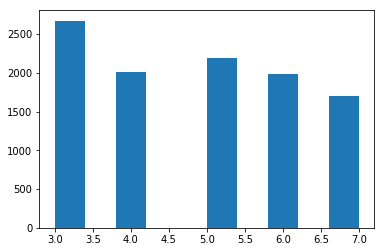

In [146]:
#dataset1 = TUDataset(root='temp/'+thename, name='REDDIT-BINARY')
dataset = get_planetoid_dataset(root='temp/planetoid',name='Cora', normalize_features=True)
#inspectGraphDataset(dataset, thename)
data, y_discrete, num_features, num_classes, num_edges, num_edge_features = dataset_preprocessing(
    dataset[0], 
    num_features=dataset.num_features)

In [198]:
permute_masks = random_planetoid_splits 
num_features = 1
num_classes = 5
run(dataset,
    y_discrete, 
    num_classes, 
    META1( 
        num_classes=num_classes,
        num_edge_features=1, # for eache edge only 1 feature
        num_features=dataset.num_features, 
        edge_attr = torch.FloatTensor(data.edge_attr), 
        num_edges=len(data.edge_attr),
        d4 =19,d5=16,
        hidden_units=10,
        out_units_edge=19,
        out_units_node1=16,
        out_units_node2=15,
    ), 
    100, # runs 
    20, # epochs
    0.01,  # lr
    0.0005, #wd
    10, permute_masks,
    tr_mask_length=20, val_mask_length=500, test_mask_length=1500,
    results_file='GN_exp1_semisuperv.csv',
    continuous_targets=data.y,
    continuous_bins=data.undiscretize)

# Original

RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15
Val Loss: 1.6182, Test Accuracy: 0.184 ± 0.006, Duration: 0.066


RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15


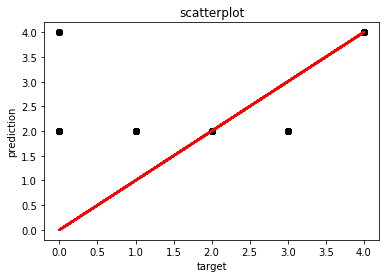

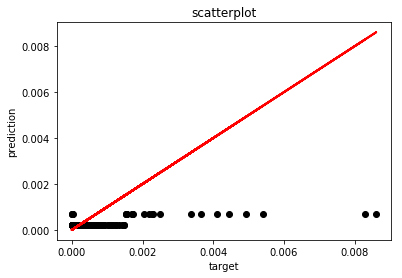

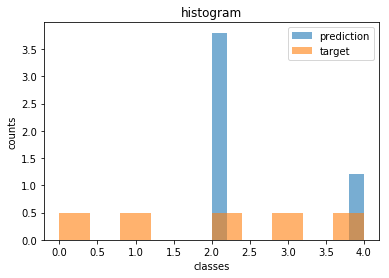

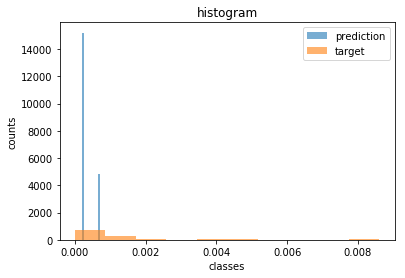

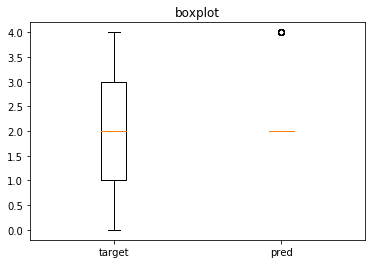

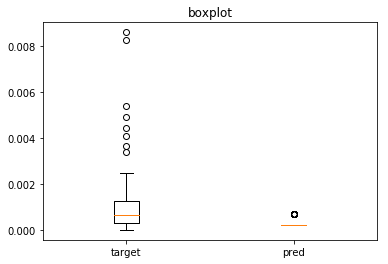

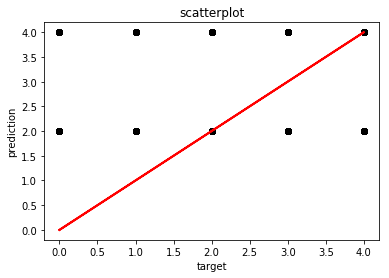

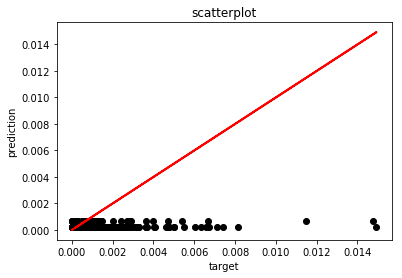

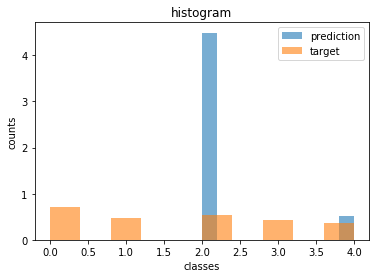

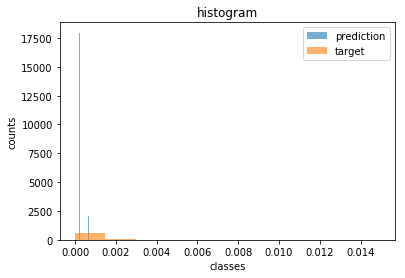

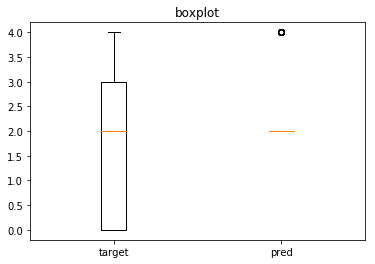

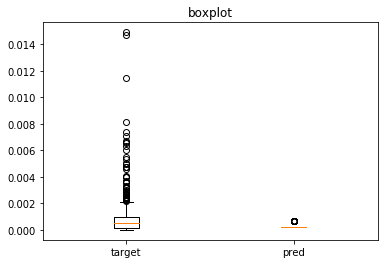

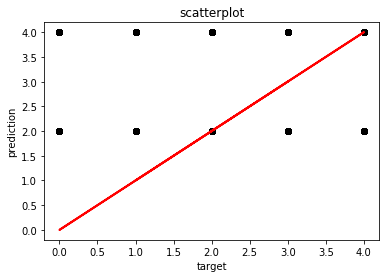

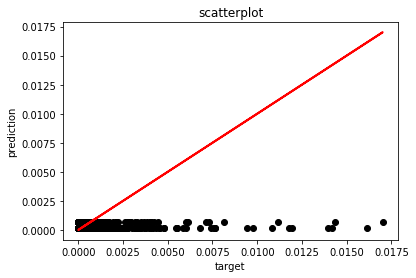

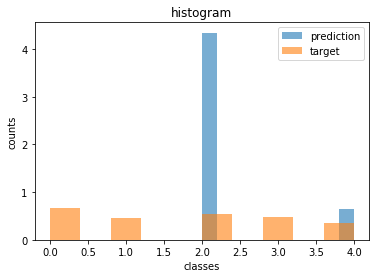

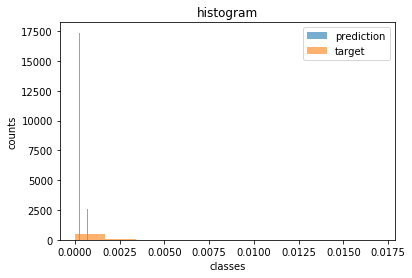

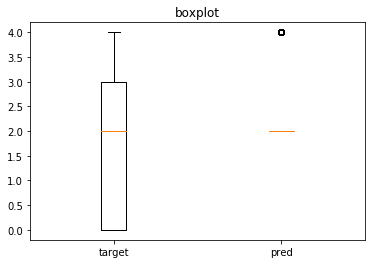

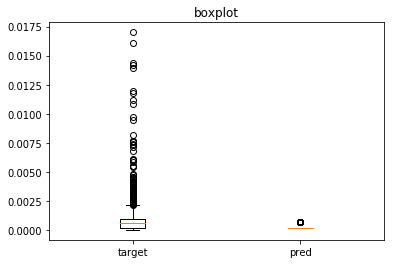

Val Loss: 1.6032, Test Accuracy: 0.216 ± 0.004, Duration: 2.377


In [199]:
permute_masks = random_planetoid_splits 
num_features = 1
num_classes = 5
run(dataset,
    y_discrete, 
    num_classes, 
    META1( 
        num_classes=num_classes,
        num_edge_features=1, # for eache edge only 1 feature
        num_features=dataset.num_features, 
        edge_attr = torch.FloatTensor(data.edge_attr), 
        num_edges=len(data.edge_attr),
        d4 =19,d5=16,
        hidden_units=10,
        out_units_edge=19,
        out_units_node1=16,
        out_units_node2=15,
    ), 
    2, # runs 
    20, # epochs
    0.01,  # lr
    0.0005, #wd
    10, permute_masks,
    tr_mask_length=20, val_mask_length=500, test_mask_length=1500,
    results_file='GN_exp1_semisuperv.csv',
    continuous_targets=data.y,
    continuous_bins=data.undiscretize)

# Original

RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15


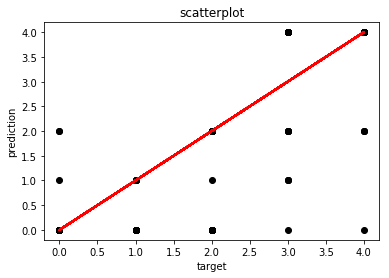

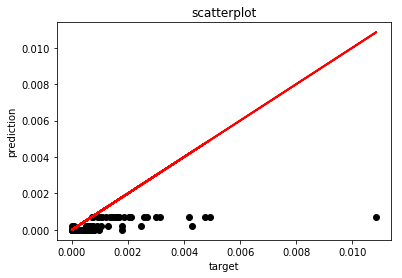

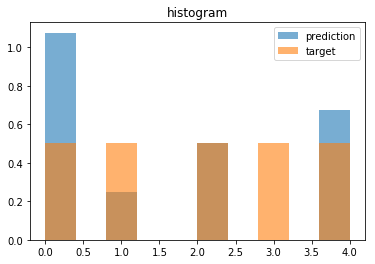

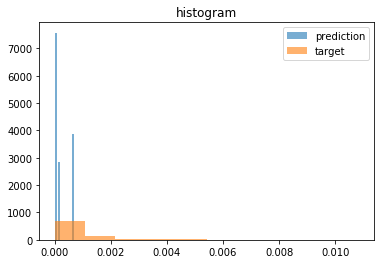

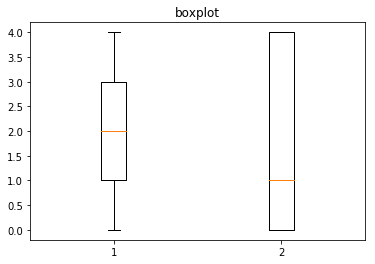

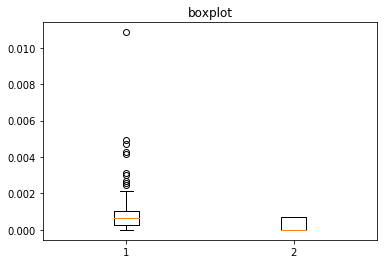

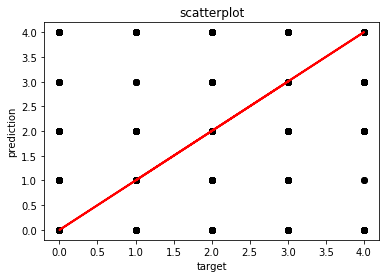

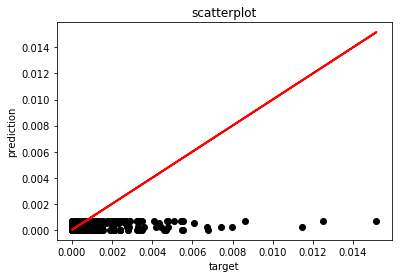

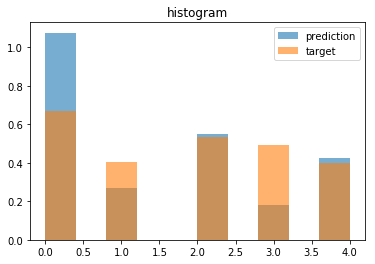

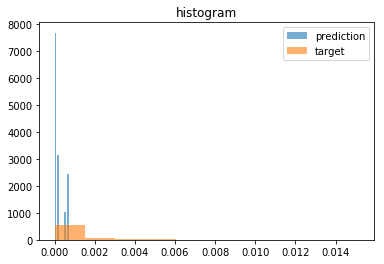

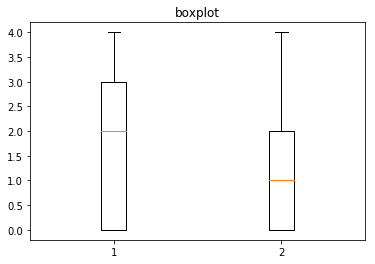

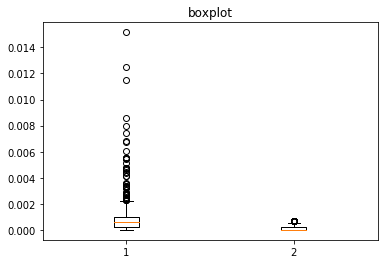

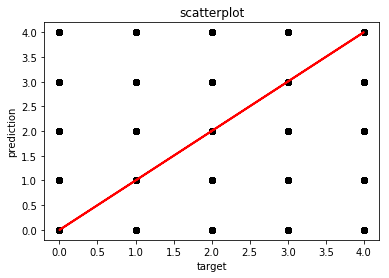

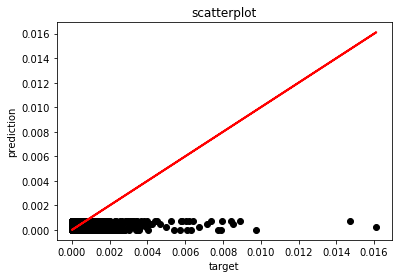

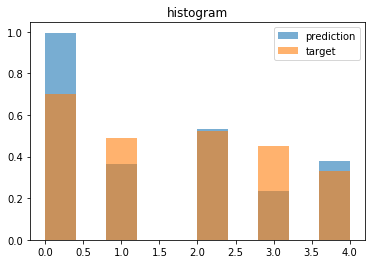

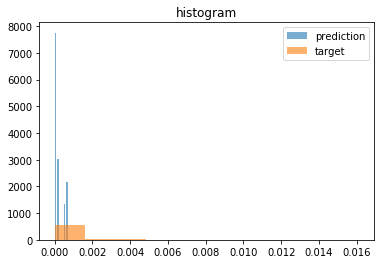

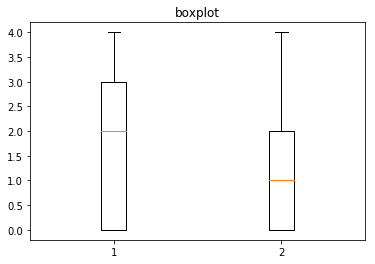

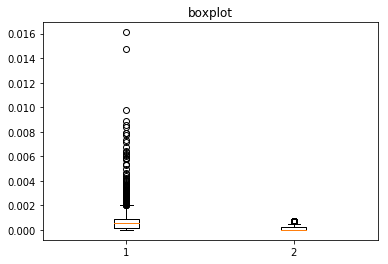

Val Loss: 1.7550, Test Accuracy: 0.296 ± 0.031, Duration: 0.494


In [152]:
permute_masks = random_planetoid_splits 
num_features = 1
num_classes = 5
run(dataset,
    y_discrete, 
    num_classes, 
    META1( 
        num_classes=num_classes,
        num_edge_features=1, # for eache edge only 1 feature
        num_features=dataset.num_features, 
        edge_attr = torch.FloatTensor(data.edge_attr), 
        num_edges=len(data.edge_attr),
        d4 =19,d5=16,
        hidden_units=10,
        out_units_edge=19,
        out_units_node1=16,
        out_units_node2=15,
    ), 
    100, # runs 
    20, # epochs
    0.01,  # lr
    0.0005, #wd
    10, permute_masks,
    tr_mask_length=20, val_mask_length=500, test_mask_length=1500,
    results_file='GN_exp1_semisuperv.csv',
    continuous_targets=data.y,
    continuous_bins=data.undiscretize)

# tr small, val small, test small

RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15


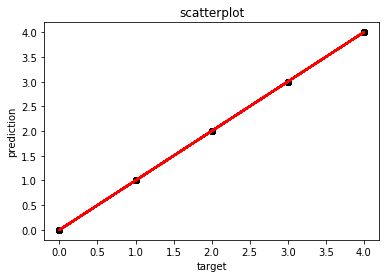

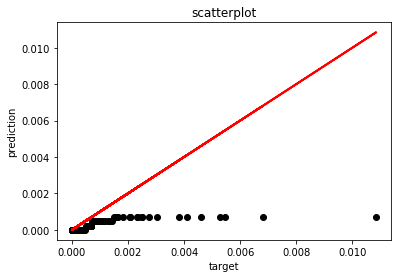

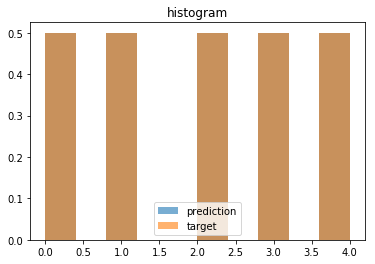

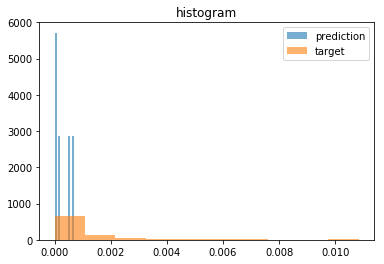

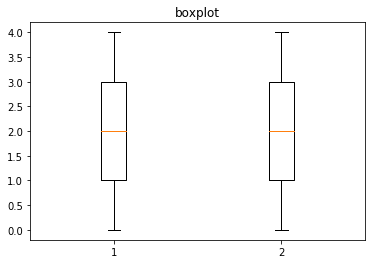

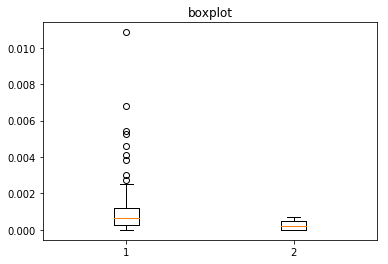

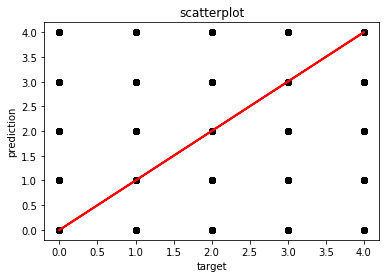

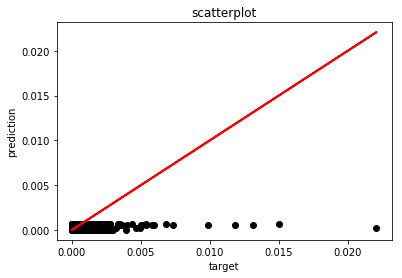

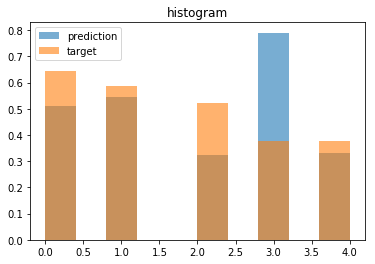

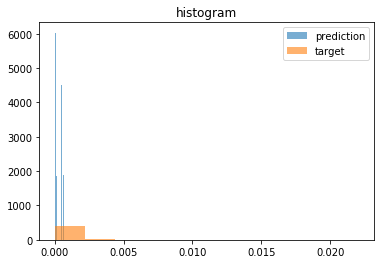

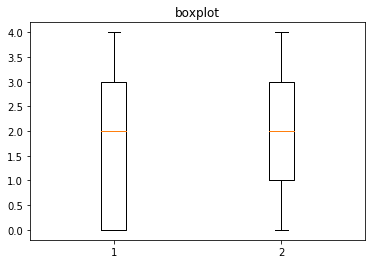

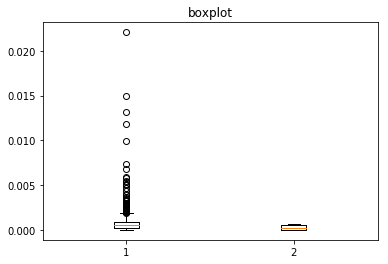

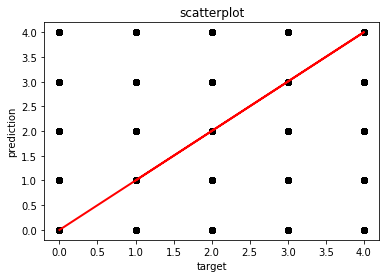

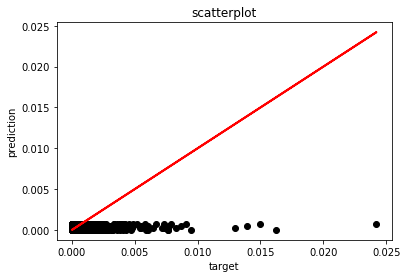

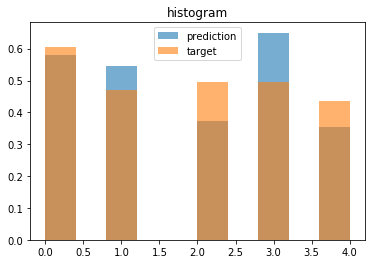

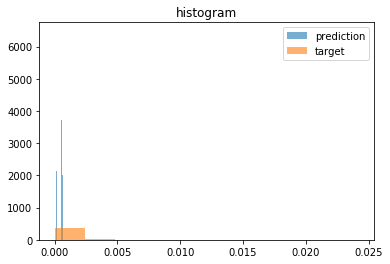

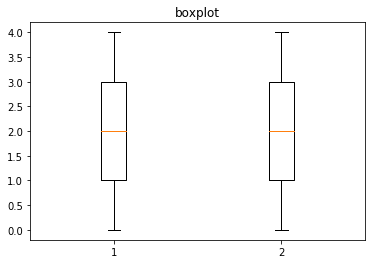

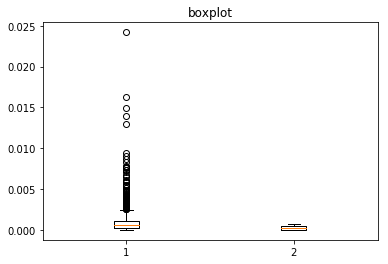

Val Loss: 2.7132, Test Accuracy: 0.274 ± 0.019, Duration: 3.518


In [153]:
permute_masks = random_planetoid_splits 
num_features = 1
num_classes = 5
run(dataset,
    y_discrete, 
    num_classes, 
    META1( 
        num_classes=num_classes,
        num_edge_features=1, # for eache edge only 1 feature
        num_features=dataset.num_features, 
        edge_attr = torch.FloatTensor(data.edge_attr), 
        num_edges=len(data.edge_attr),
        d4 =19,d5=16,
        hidden_units=10,
        out_units_edge=19,
        out_units_node1=16,
        out_units_node2=15,
    ), 
    100, # runs 
    200, # epochs
    0.01,  # lr
    0.0005, #wd
    10, permute_masks,
    tr_mask_length=20, val_mask_length=500, test_mask_length=1500,
    results_file='GN_exp1_semisuperv.csv',
    continuous_targets=data.y,
    continuous_bins=data.undiscretize)

# tr small, val small, test small

RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15


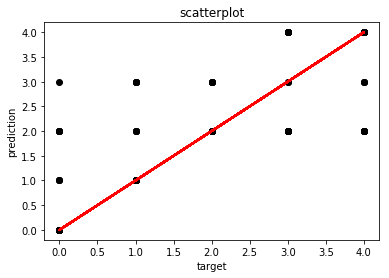

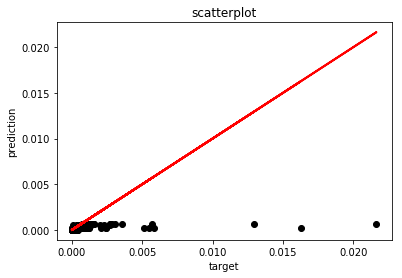

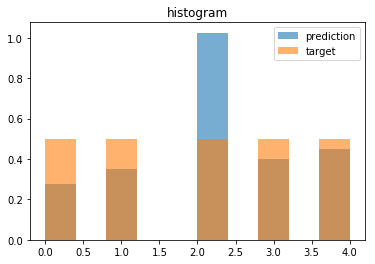

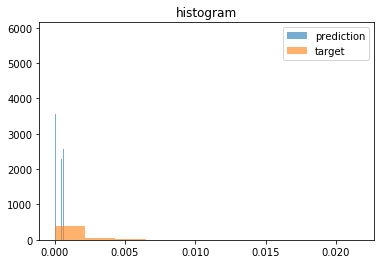

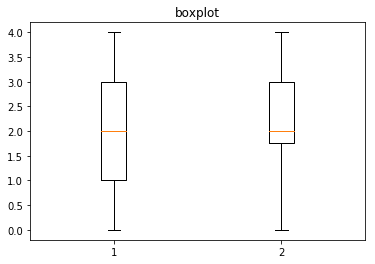

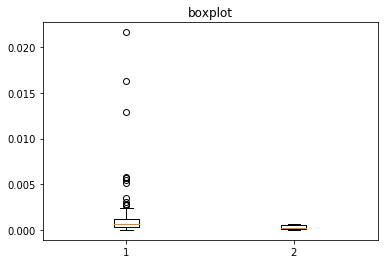

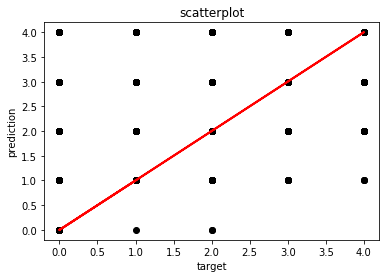

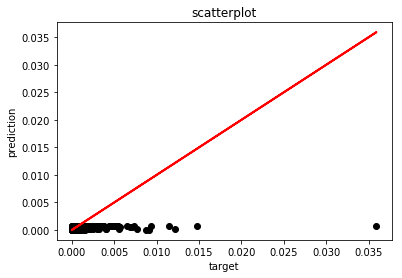

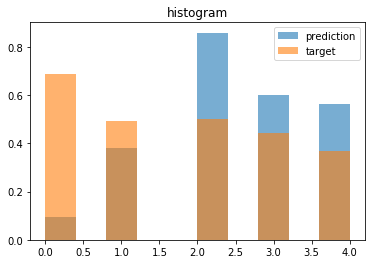

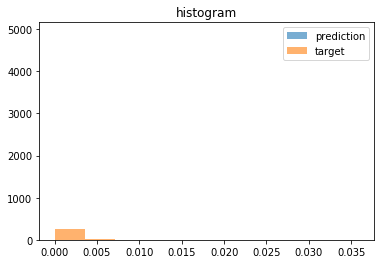

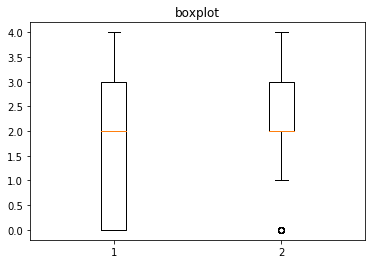

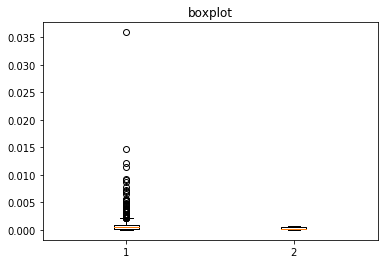

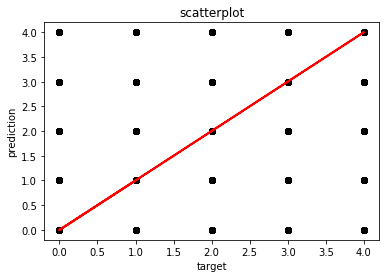

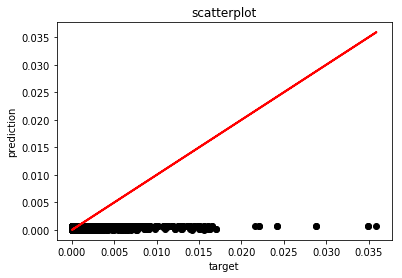

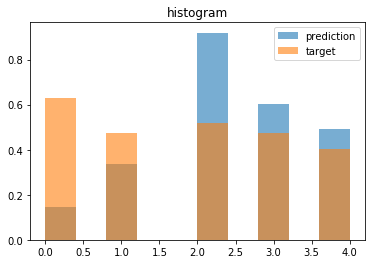

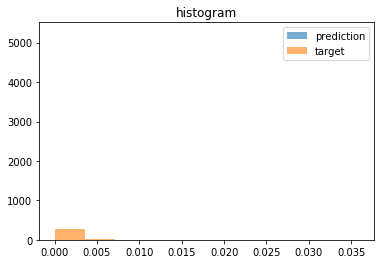

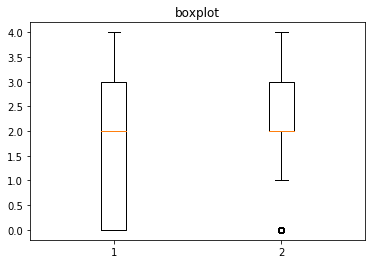

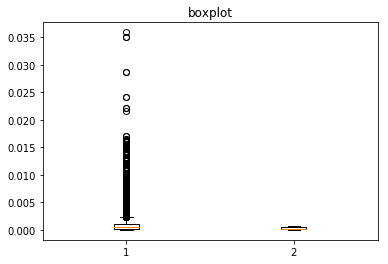

Val Loss: 1.7508, Test Accuracy: 0.293 ± 0.023, Duration: 0.547


In [154]:
permute_masks = random_planetoid_splits 
num_features = 1
num_classes = 5
run(dataset,
    y_discrete, 
    num_classes, 
    META1( 
        num_classes=num_classes,
        num_edge_features=1, # for eache edge only 1 feature
        num_features=dataset.num_features, 
        edge_attr = torch.FloatTensor(data.edge_attr), 
        num_edges=len(data.edge_attr),
        d4 =19,d5=16,
        hidden_units=10,
        out_units_edge=19,
        out_units_node1=16,
        out_units_node2=15,
    ), 
    100, # runs 
    20, # epochs
    0.01,  # lr
    0.0005, #wd
    10, permute_masks,
    tr_mask_length=20, val_mask_length=500, test_mask_length=len(data.y),
    results_file='GN_exp1_semisuperv.csv',
    continuous_targets=data.y,
    continuous_bins=data.undiscretize)

# tr small, val small, test big

RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15


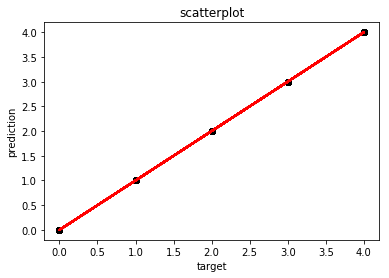

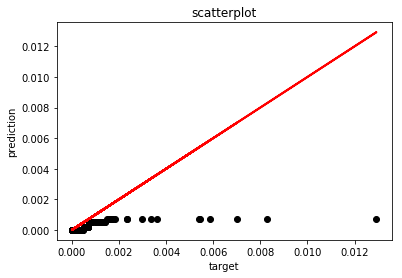

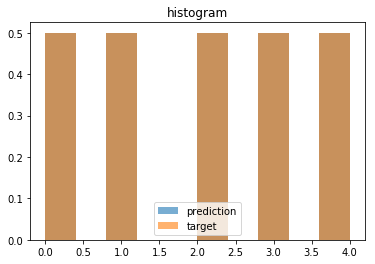

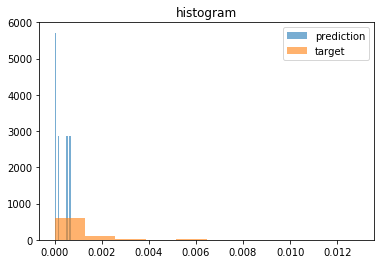

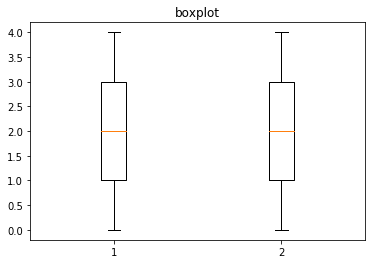

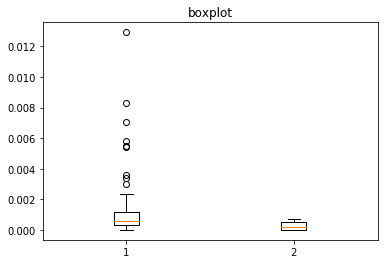

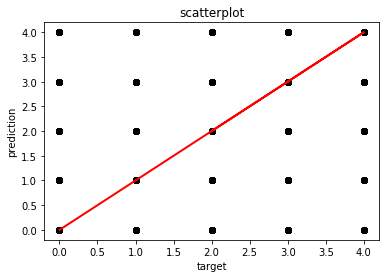

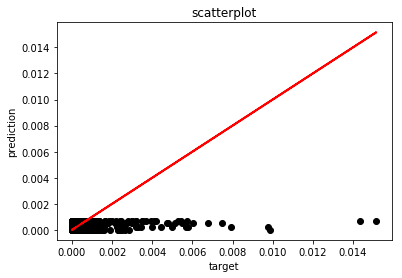

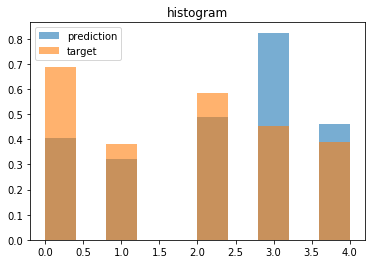

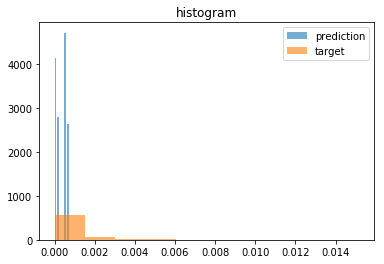

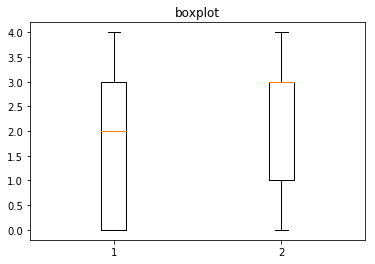

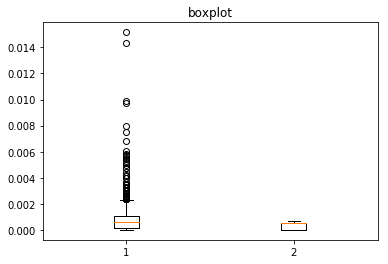

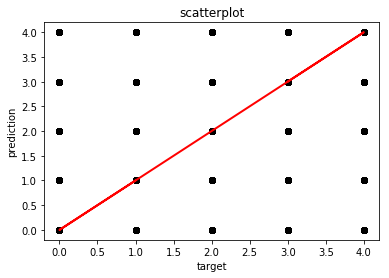

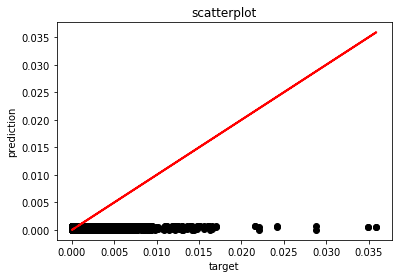

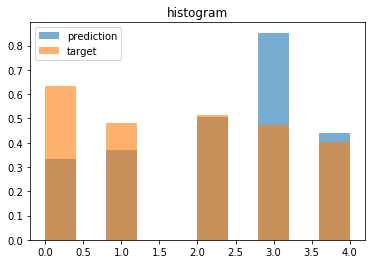

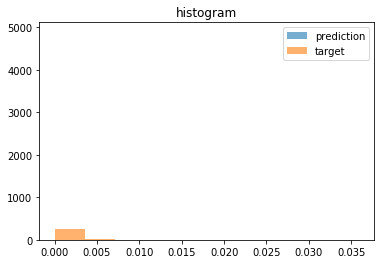

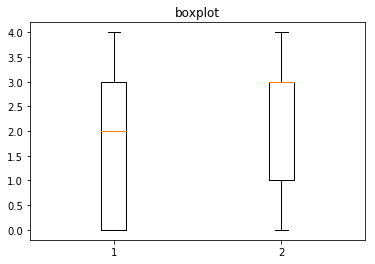

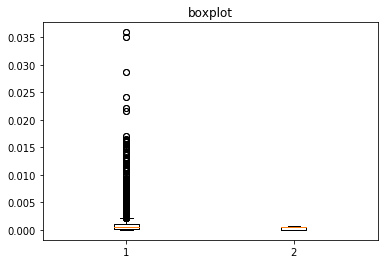

Val Loss: 2.8676, Test Accuracy: 0.266 ± 0.013, Duration: 3.743


In [155]:
permute_masks = random_planetoid_splits 
num_features = 1
num_classes = 5
run(dataset,
    y_discrete, 
    num_classes, 
    META1( 
        num_classes=num_classes,
        num_edge_features=1, # for eache edge only 1 feature
        num_features=dataset.num_features, 
        edge_attr = torch.FloatTensor(data.edge_attr), 
        num_edges=len(data.edge_attr),
        d4 =19,d5=16,
        hidden_units=10,
        out_units_edge=19,
        out_units_node1=16,
        out_units_node2=15,
    ), 
    100, # runs 
    200, # epochs
    0.01,  # lr
    0.0005, #wd
    10, permute_masks,
    tr_mask_length=20, val_mask_length=500, test_mask_length=len(data.y),
    results_file='GN_exp1_semisuperv.csv',
    continuous_targets=data.y,
    continuous_bins=data.undiscretize)

# tr small, val small, test big

RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15


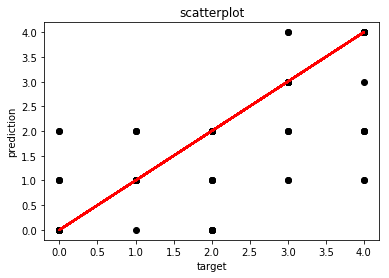

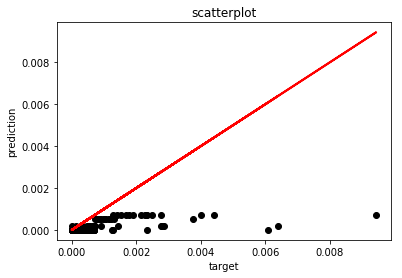

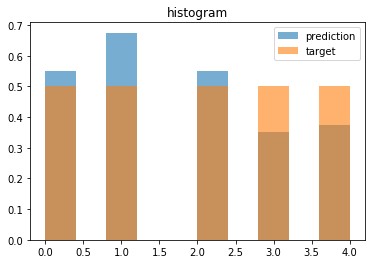

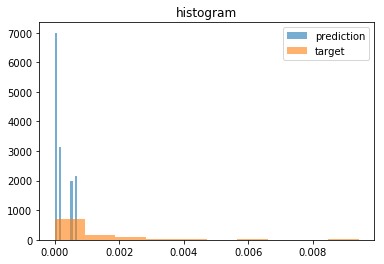

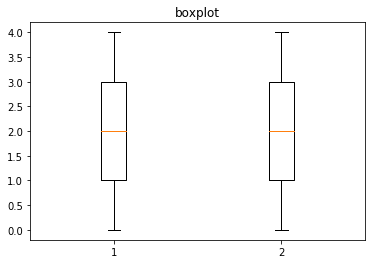

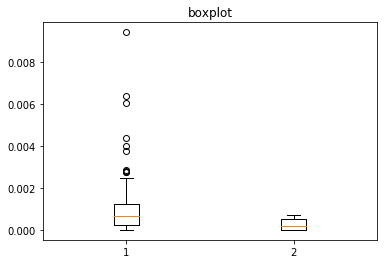

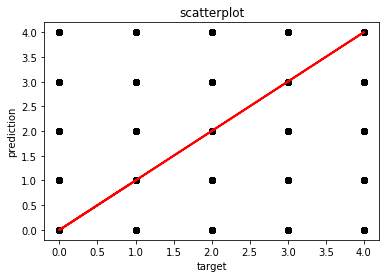

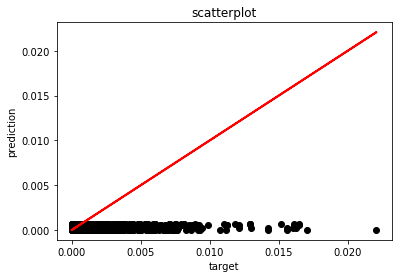

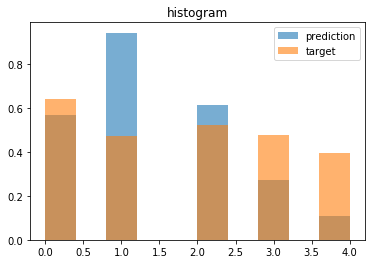

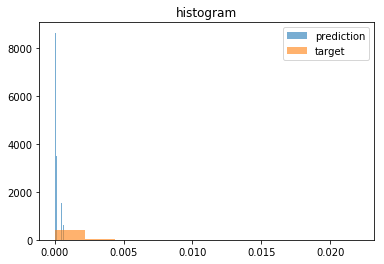

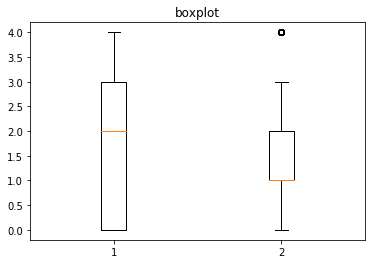

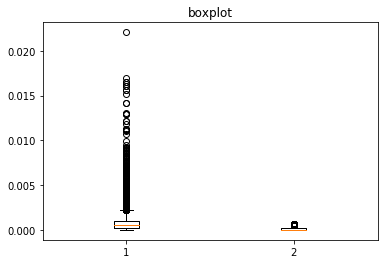

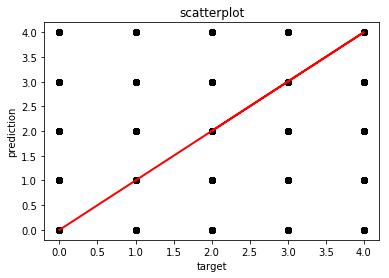

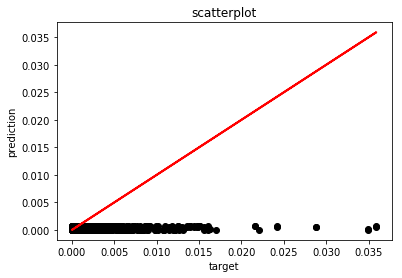

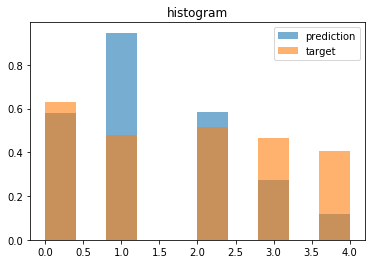

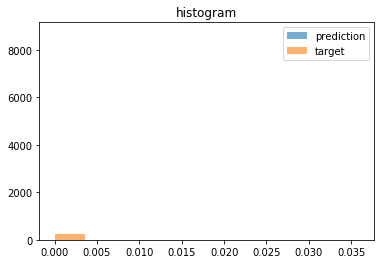

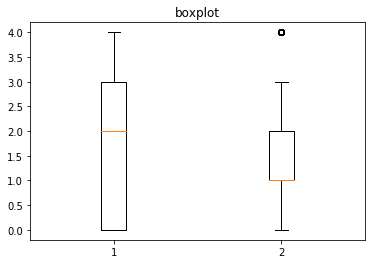

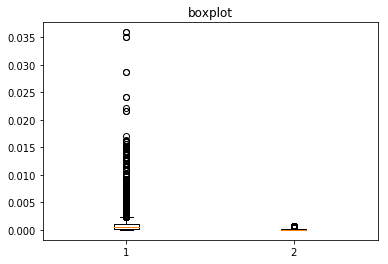

Val Loss: 1.7437, Test Accuracy: 0.296 ± 0.026, Duration: 0.528


In [156]:
permute_masks = random_planetoid_splits 
num_features = 1
num_classes = 5
run(dataset,
    y_discrete, 
    num_classes, 
    META1( 
        num_classes=num_classes,
        num_edge_features=1, # for eache edge only 1 feature
        num_features=dataset.num_features, 
        edge_attr = torch.FloatTensor(data.edge_attr), 
        num_edges=len(data.edge_attr),
        d4 =19,d5=16,
        hidden_units=10,
        out_units_edge=19,
        out_units_node1=16,
        out_units_node2=15,
    ), 
    100, # runs 
    20, # epochs
    0.01,  # lr
    0.0005, #wd
    10, permute_masks,
    tr_mask_length=20, val_mask_length=4000, test_mask_length=len(data.y),
    results_file='GN_exp1_semisuperv.csv',
    continuous_targets=data.y,
    continuous_bins=data.undiscretize)

# tr small, val big, test big

RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15


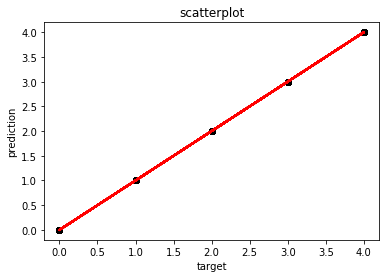

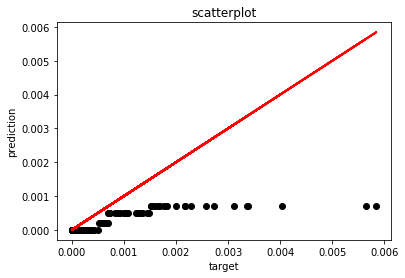

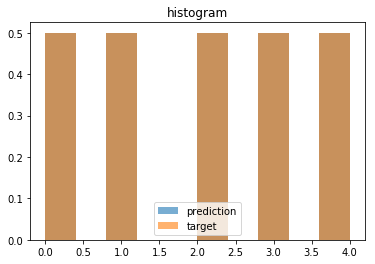

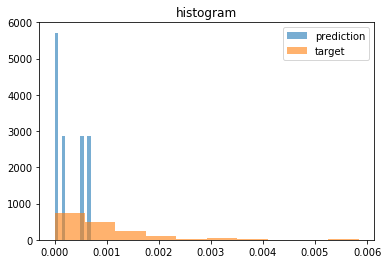

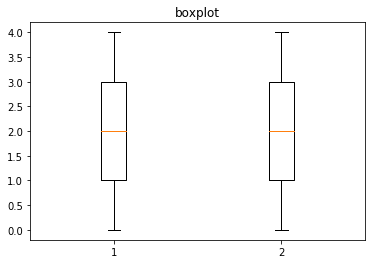

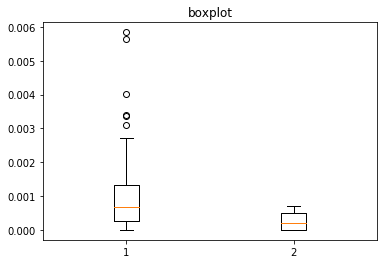

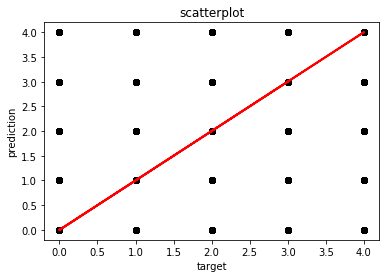

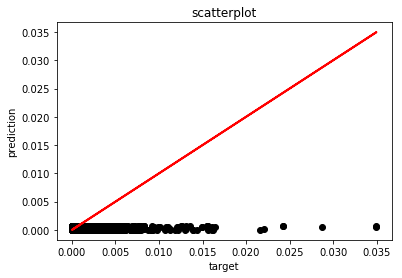

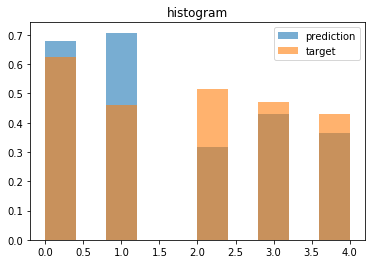

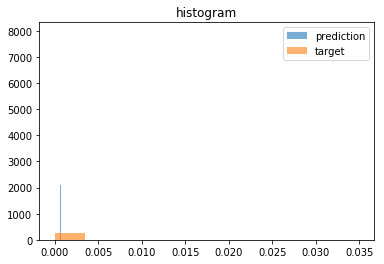

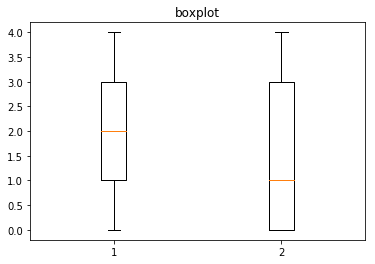

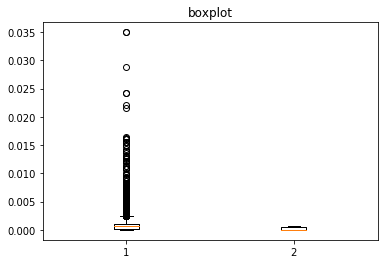

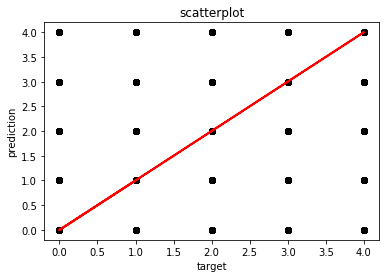

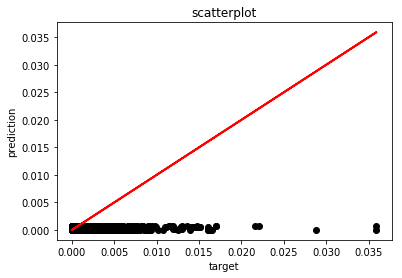

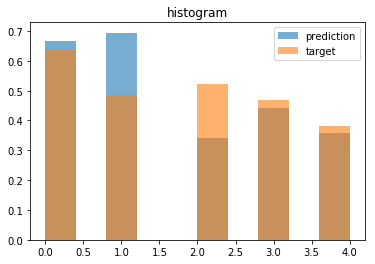

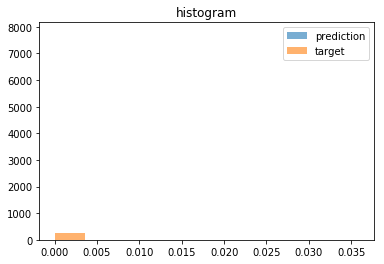

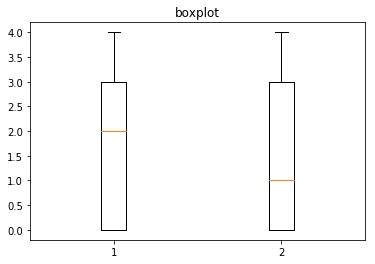

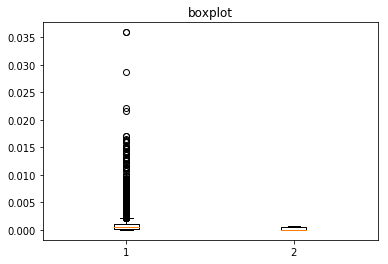

Val Loss: 2.8105, Test Accuracy: 0.265 ± 0.016, Duration: 3.704


In [157]:
permute_masks = random_planetoid_splits 
num_features = 1
num_classes = 5
run(dataset,
    y_discrete, 
    num_classes, 
    META1( 
        num_classes=num_classes,
        num_edge_features=1, # for eache edge only 1 feature
        num_features=dataset.num_features, 
        edge_attr = torch.FloatTensor(data.edge_attr), 
        num_edges=len(data.edge_attr),
        d4 =19,d5=16,
        hidden_units=10,
        out_units_edge=19,
        out_units_node1=16,
        out_units_node2=15,
    ), 
    100, # runs 
    200, # epochs
    0.01,  # lr
    0.0005, #wd
    10, permute_masks,
    tr_mask_length=20, val_mask_length=4000, test_mask_length=len(data.y),
    results_file='GN_exp1_semisuperv.csv',
    continuous_targets=data.y,
    continuous_bins=data.undiscretize)

# tr small, val big, test big

RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15


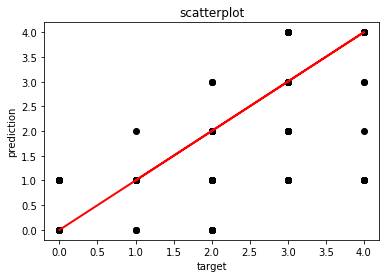

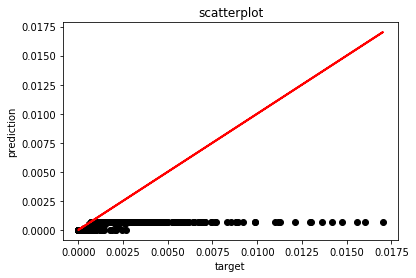

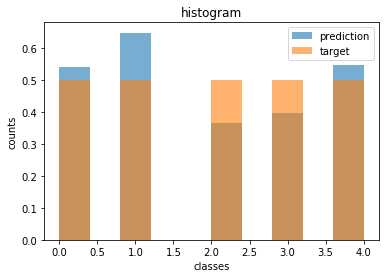

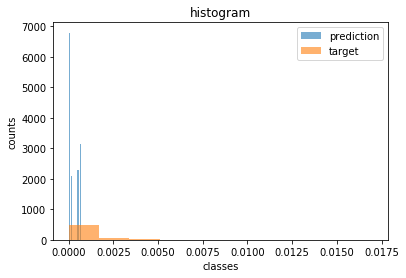

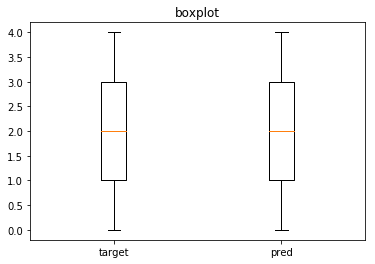

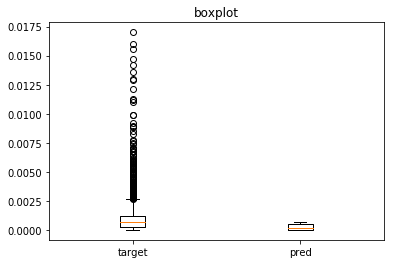

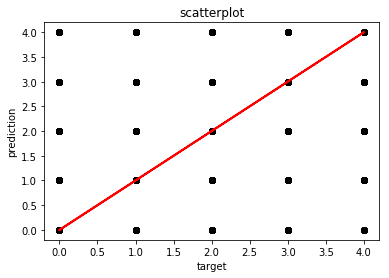

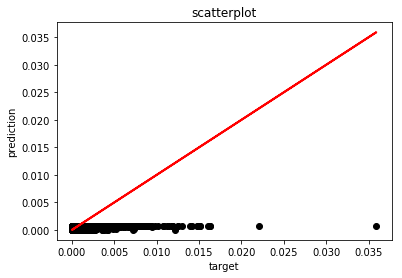

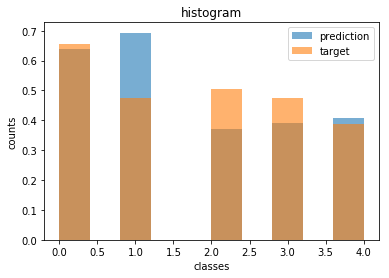

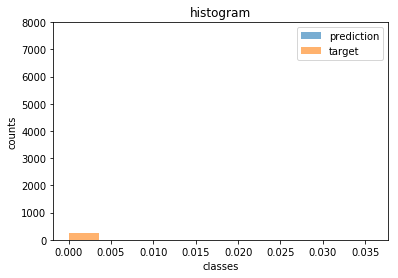

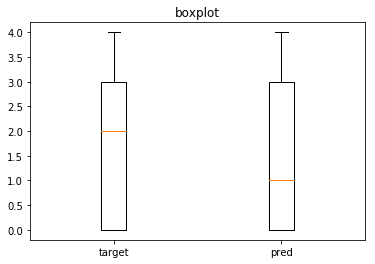

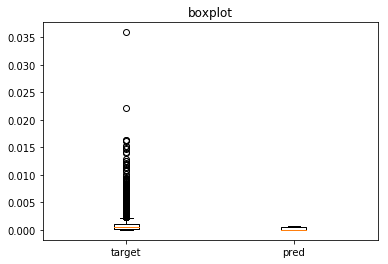

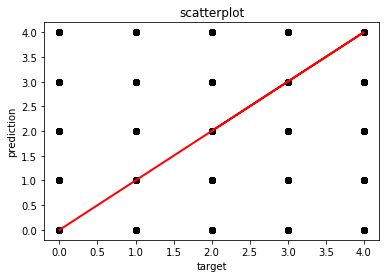

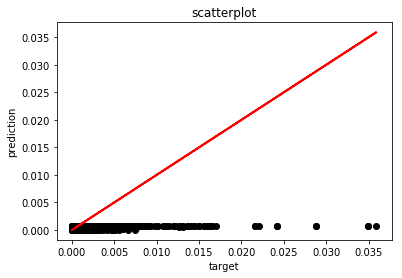

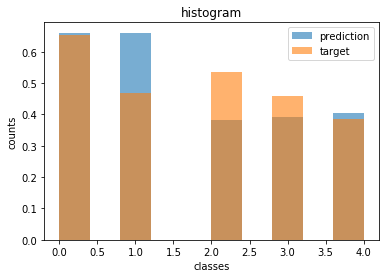

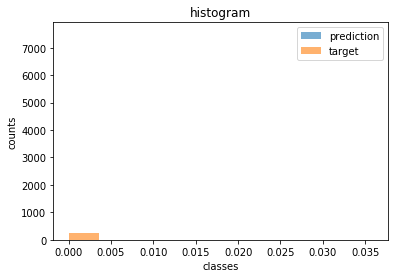

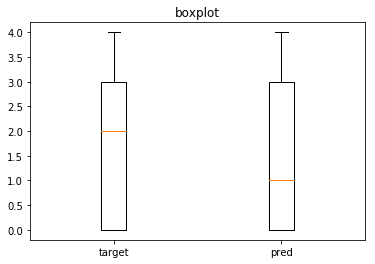

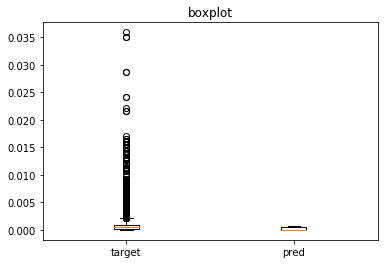

Val Loss: 1.1604, Test Accuracy: 0.555 ± 0.077, Duration: 0.425


In [200]:
permute_masks = random_planetoid_splits 
num_features = 1
num_classes = 5
run(dataset,
    y_discrete, 
    num_classes, 
    META1( 
        num_classes=num_classes,
        num_edge_features=1, # for eache edge only 1 feature
        num_features=dataset.num_features, 
        edge_attr = torch.FloatTensor(data.edge_attr), 
        num_edges=len(data.edge_attr),
        d4 =19,d5=16,
        hidden_units=10,
        out_units_edge=19,
        out_units_node1=16,
        out_units_node2=15,
    ), 
    100, # runs 
    20, # epochs
    0.01,  # lr
    0.0005, #wd
    10, permute_masks,
    tr_mask_length=300, val_mask_length=4000, test_mask_length=len(data.y),
    results_file='GN_exp1_semisuperv.csv',
    continuous_targets=data.y,
    continuous_bins=data.undiscretize)

# tr mid, val big, test big

RUn  _d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15


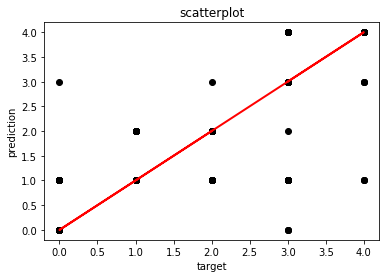

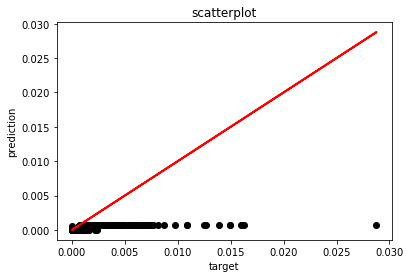

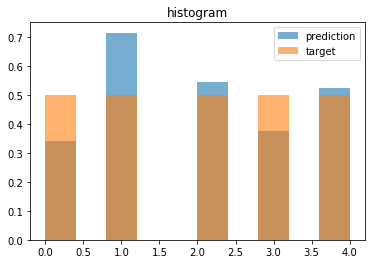

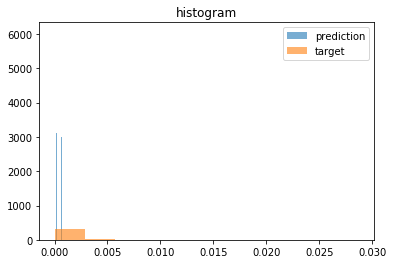

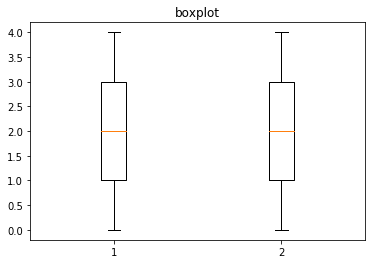

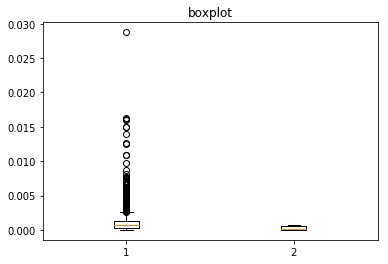

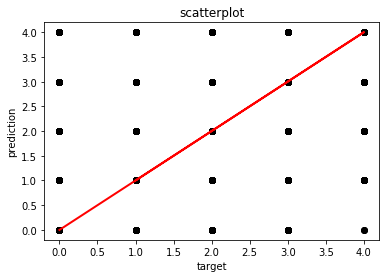

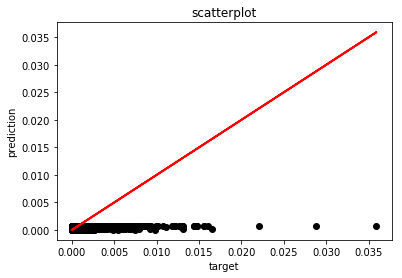

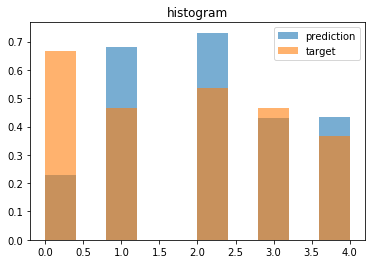

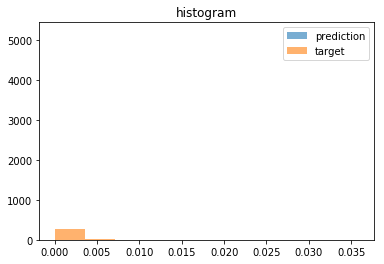

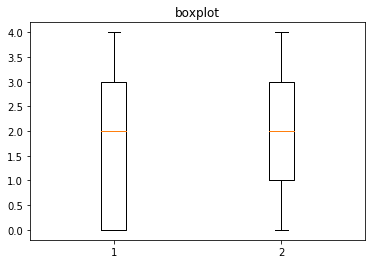

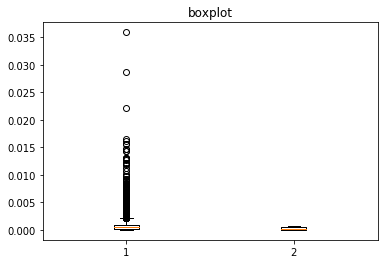

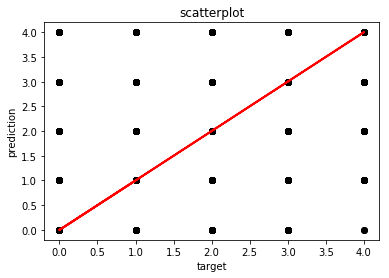

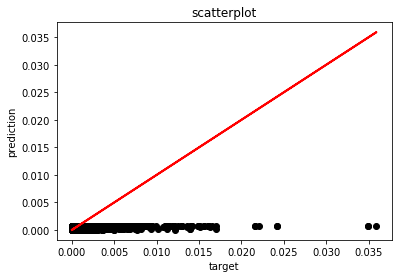

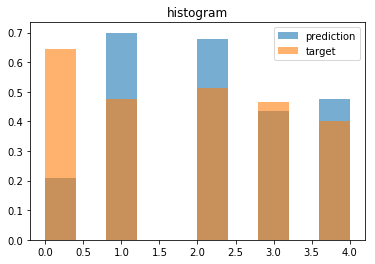

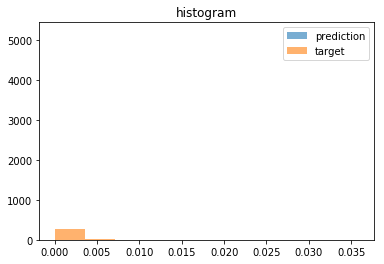

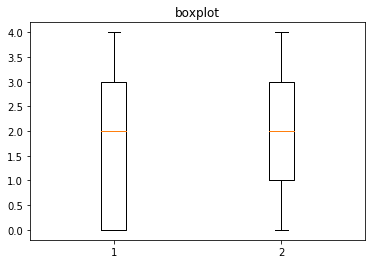

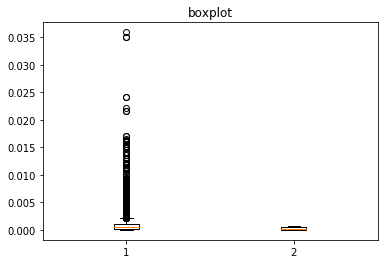

Val Loss: 2.3160, Test Accuracy: 0.409 ± 0.033, Duration: 3.546


In [159]:
permute_masks = random_planetoid_splits 
num_features = 1
num_classes = 5
run(dataset,
    y_discrete, 
    num_classes, 
    META1( 
        num_classes=num_classes,
        num_edge_features=1, # for eache edge only 1 feature
        num_features=dataset.num_features, 
        edge_attr = torch.FloatTensor(data.edge_attr), 
        num_edges=len(data.edge_attr),
        d4 =19,d5=16,
        hidden_units=10,
        out_units_edge=19,
        out_units_node1=16,
        out_units_node2=15,
    ), 
    100, # runs 
    200, # epochs
    0.01,  # lr
    0.0005, #wd
    10, permute_masks,
    tr_mask_length=300, val_mask_length=4000, test_mask_length=len(data.y),
    results_file='GN_exp1_semisuperv.csv',
    continuous_targets=data.y,
    continuous_bins=data.undiscretize)

# tr mid, val big, test big

RUn  _d4=10_d5=10_hus=10_eus=10_n1us=10_n2us=10


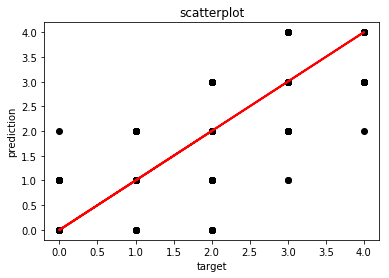

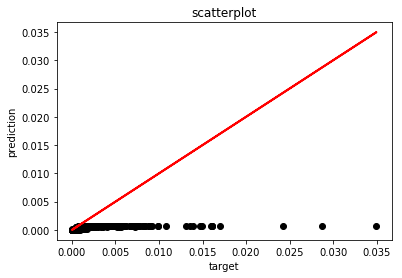

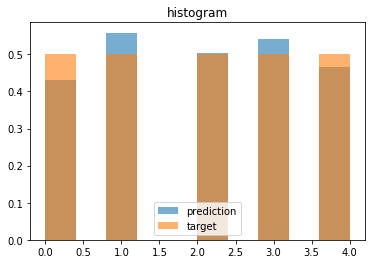

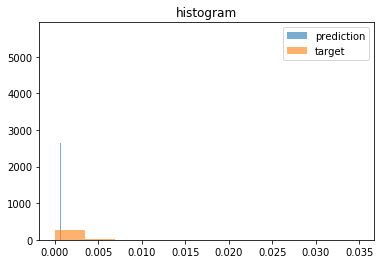

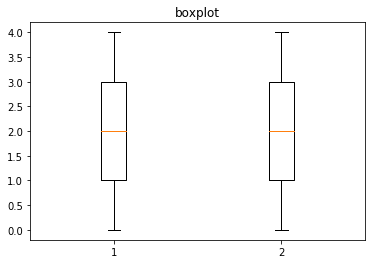

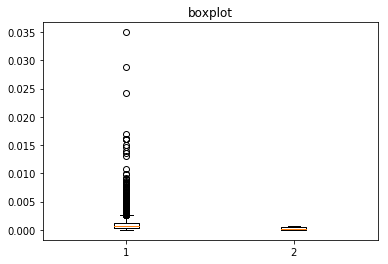

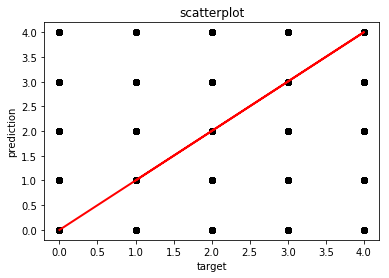

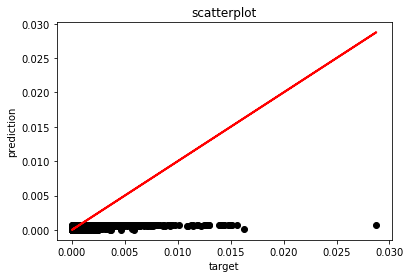

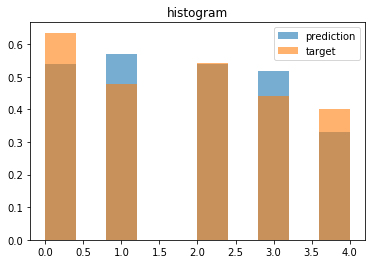

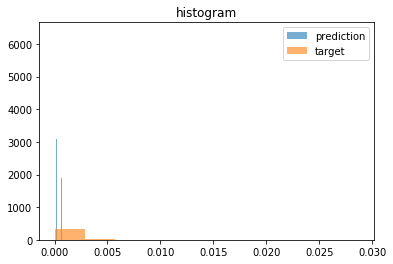

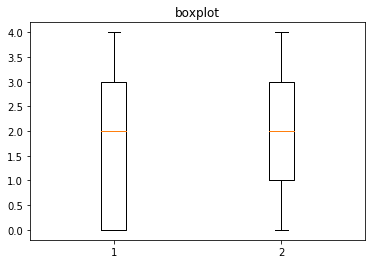

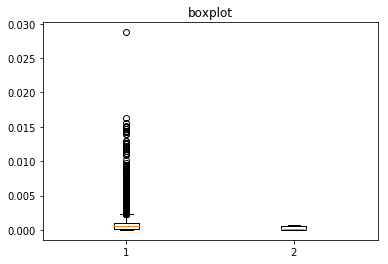

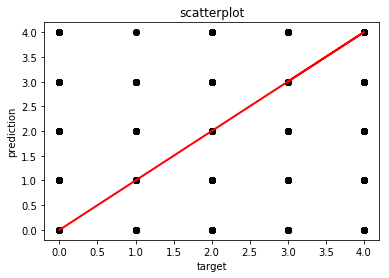

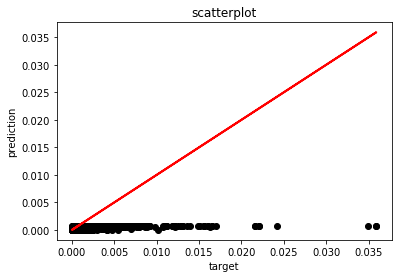

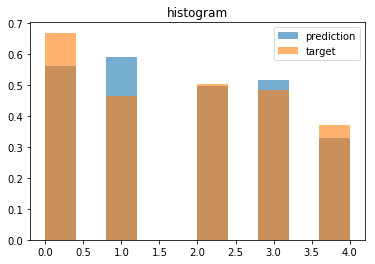

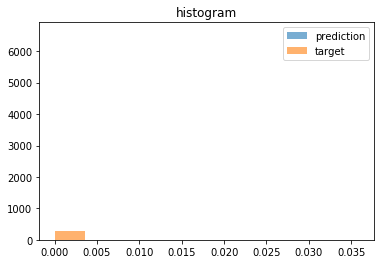

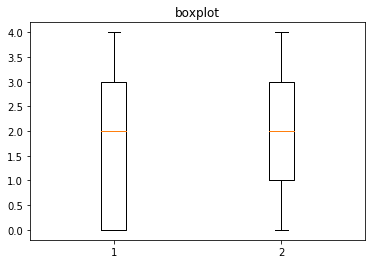

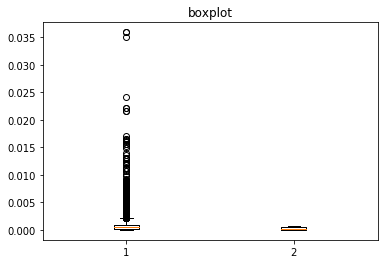

Val Loss: 1.1565, Test Accuracy: 0.537 ± 0.074, Duration: 0.494


In [160]:
permute_masks = random_planetoid_splits 
num_features = 1
num_classes = 5
run(dataset,
    y_discrete, 
    num_classes, 
    META1(   # Changing the hidden_units !!
        num_classes=num_classes,
        num_edge_features=1, # for eache edge only 1 feature
        num_features=dataset.num_features, 
        edge_attr = torch.FloatTensor(data.edge_attr), 
        num_edges=len(data.edge_attr),
        d4 =10,d5=10,
        hidden_units=10,
        out_units_edge=10,
        out_units_node1=10,
        out_units_node2=10
    ), 
    100, # runs 
    20, # epochs
    0.01,  # lr
    0.0005, #wd
    10, permute_masks,
    tr_mask_length=300, val_mask_length=4000, test_mask_length=len(data.y),
    results_file='GN_exp1_semisuperv.csv',
    continuous_targets=data.y,
    continuous_bins=data.undiscretize)

# tr mid, val big, test big

RUn  _d4=10_d5=10_hus=10_eus=10_n1us=10_n2us=10


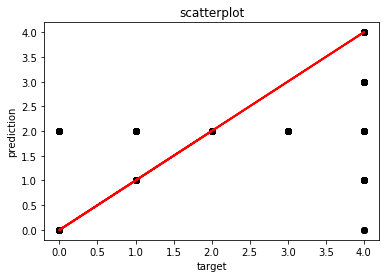

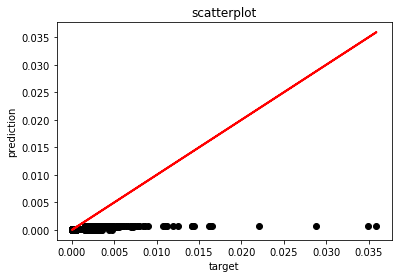

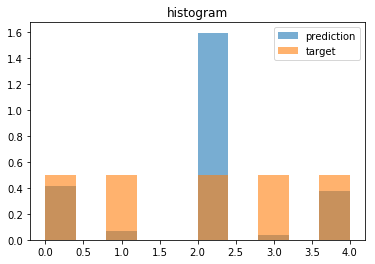

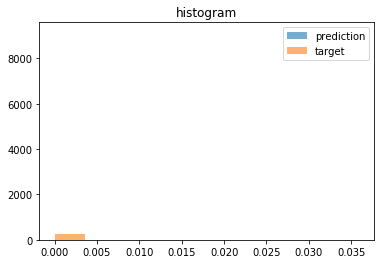

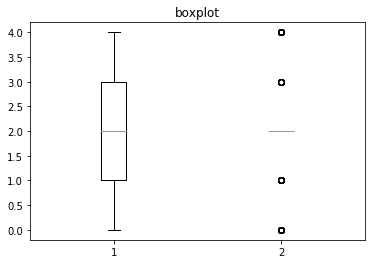

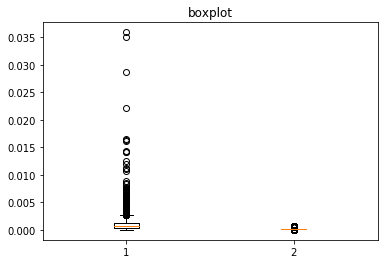

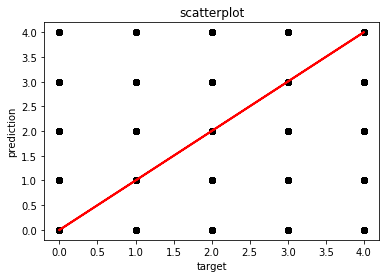

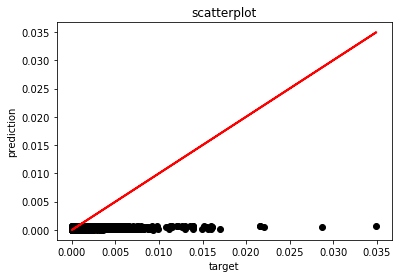

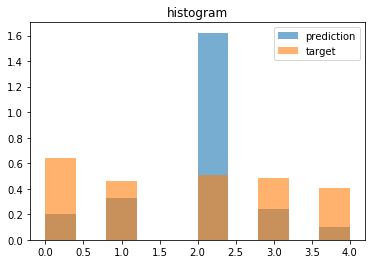

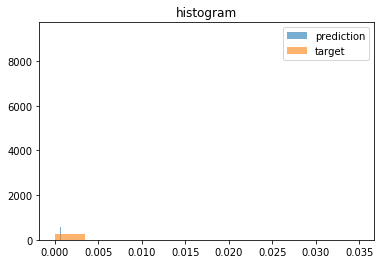

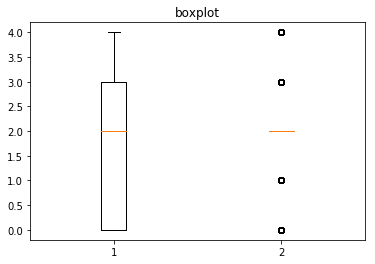

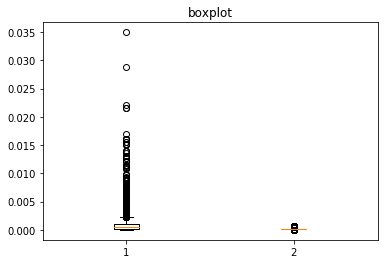

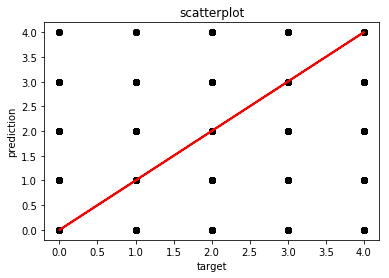

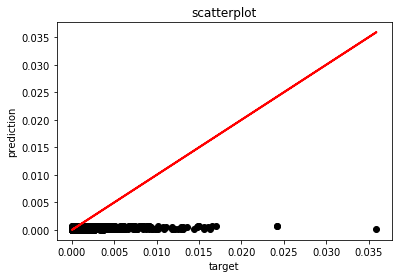

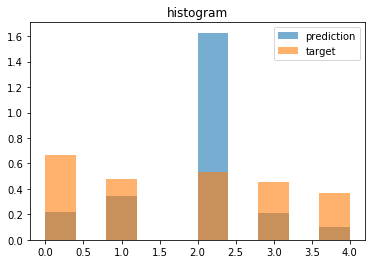

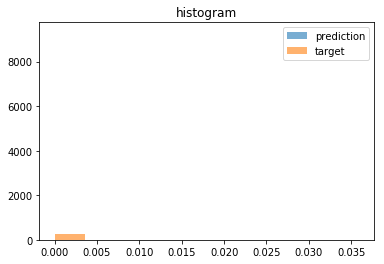

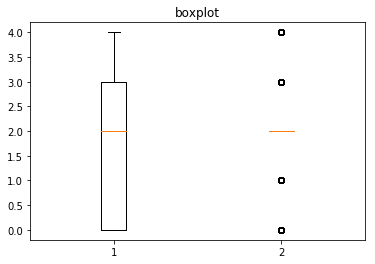

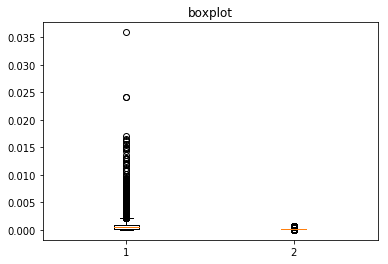

Val Loss: 2.1036, Test Accuracy: 0.374 ± 0.030, Duration: 3.593


In [161]:
permute_masks = random_planetoid_splits 
num_features = 1
num_classes = 5
run(dataset,
    y_discrete, 
    num_classes, 
    META1(   # Changing the hidden_units !!
        num_classes=num_classes,
        num_edge_features=1, # for eache edge only 1 feature
        num_features=dataset.num_features, 
        edge_attr = torch.FloatTensor(data.edge_attr), 
        num_edges=len(data.edge_attr),
        d4 =10,d5=10,
        hidden_units=10,
        out_units_edge=10,
        out_units_node1=10,
        out_units_node2=10
    ), 
    100, # runs 
    200, # epochs
    0.01,  # lr
    0.0005, #wd
    10, permute_masks,
    tr_mask_length=300, val_mask_length=4000, test_mask_length=len(data.y),
    results_file='GN_exp1_semisuperv.csv',
    continuous_targets=data.y,
    continuous_bins=data.undiscretize)

# tr mid, val big, test big

## Reporting

In [186]:
reporting_from_csv('GN_exp1_semisuperv.csv',label='Experiment1',title='Edge betweenness approximation with a graph neural network experiment')

,Model,Parameters,Loss,Accuracy,Time(min)
0,META1,d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=1_epochs=2_split-20-500-1500,1.6367,0.239 ± nan,0.069
1,META1,d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=1_epochs=2_split-20-500-1500,1.6338,0.146 ± nan,0.071
2,META1,d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=1_epochs=2_split-20-500-1500,1.6308,0.189 ± nan,0.069
3,META1,d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=1_epochs=2_split-20-500-1500,1.6049,0.273 ± nan,0.071
4,META1,d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=1_epochs=2_split-20-500-1500,1.6059,0.218 ± nan,5.921
5,META1,d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=1_epochs=2_split-20-500-1500,1.6045,0.252 ± nan,4.065
6,META1,d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=20_split-20-500-1500,1.7550,0.296 ± 0.031,0.494
7,META1,d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=200_split-20-500-1500,2.7132,0.274 ± 0.019,3.518
8,META1,d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=20_split-20-500-10556,1.7508,0.293 ± 0.023,0.547
9,META1,d4=19_d5=16_hus=10_eus=19_n1us=16_n2us=15_r=100_epochs=200_split-20-500-10556,2.8676,0.266 ± 0.013,3.743


\begin{table}[H]
\centering
\begin{tabular}{|llllccc|}
\hline
 Model &                                                                        Paramteres  &  Runs\/Epochs  &  Splits &    Loss &        Accuracy &  Time(min) \\
\hline
 META1 &          d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6367 &     0.239 ± nan &      0.069 \\
 META1 &          d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6338 &     0.146 ± nan &      0.071 \\
 META1 &          d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6308 &     0.189 ± nan &      0.069 \\
 META1 &          d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6049 &     0.273 ± nan &      0.071 \\
 META1 &          d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6059 &     0.218 ± nan &      5.921 \\
 META1 &          d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6045 &     0.252 ± nan &      4.065 \\
 META1 &       d19d16h10e19n16n15 & 100-20 & 20-500-1500 &  1.7550 &   0.296 ± 0.031 &      0.494 \\
 META1 &      d19d16h10e19n16n15 & 100-200 & 20-500-1500 &  2

'\\begin{table}[H]\n\\centering\n\\begin{tabular}{|llllccc|}\n\\hline\n Model &                                                                        Paramteres  &  Runs\\/Epochs  &  Splits &    Loss &        Accuracy &  Time(min) \\\\\n\\hline\n META1 &          d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6367 &     0.239 ± nan &      0.069 \\\\\n META1 &          d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6338 &     0.146 ± nan &      0.071 \\\\\n META1 &          d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6308 &     0.189 ± nan &      0.069 \\\\\n META1 &          d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6049 &     0.273 ± nan &      0.071 \\\\\n META1 &          d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6059 &     0.218 ± nan &      5.921 \\\\\n META1 &          d19d16h10e19n16n15 & 1-2 & 20-500-1500 &  1.6045 &     0.252 ± nan &      4.065 \\\\\n META1 &       d19d16h10e19n16n15 & 100-20 & 20-500-1500 &  1.7550 &   0.296 ± 0.031 &      0.494 \\\\\n META1 &      d19d16h10e1

## Pending remove

In [31]:
dataset.num_classes

7

In [4]:
# get dataset, see data.y is classess
data = dataset[0]
#data.y

# transform to nx
#g = pyTorchGeometricDatasetToNx(data)
g = pytorch_geometric_dataset_to_Nx2(data)

# compute node betweenness
eb = nx.edge_betweenness_centrality(g,normalized=True)
#nb = nx.betweenness_centrality(g,normalized=True)
#pr = nx.pagerank(g)


# modify data.y with node betweenness
# how to make sure that each data[i] corresponds to the node_betweenness?
# maybe that was the problem in the other dataset?

# train model, remove softmax

In [5]:
data.edge_index

tensor([[   0,    0,    0,  ..., 2707, 2707, 2707],
        [ 633, 1862, 2582,  ...,  598, 1473, 2706]])

In [6]:
eb


{(0, 633): 0.0002702912617158406,
 (0, 1862): 0.00026958819824373205,
 (0, 2582): 0.00013978354136088962,
 (633, 1701): 0.000945116766608787,
 (633, 1866): 7.030634721085485e-07,
 (1862, 926): 0.0006777112131740075,
 (1862, 1701): 0.0018607872483201247,
 (1862, 2582): 0.0002666086969801172,
 (2582, 1166): 0.0005829801845252704,
 (1, 2): 0.001655209355512029,
 (1, 652): 0.0005041480781206088,
 (1, 654): 0.0006777112131740074,
 (2, 332): 0.0010192602497925555,
 (2, 1454): 0.0006777112131740075,
 (2, 1666): 0.0010189042546367587,
 (2, 1986): 0.004402275204516611,
 (652, 470): 0.0004657232229124021,
 (332, 665): 0.0003631974195162088,
 (332, 2003): 0.0009722706010605893,
 (332, 2122): 0.0006405590813391926,
 (332, 2615): 0.0013548767651457815,
 (1666, 48): 0.00050497662963574,
 (1666, 49): 0.0006235637602452093,
 (1666, 606): 0.0008484900717771218,
 (1666, 1662): 0.00025163009640431154,
 (1666, 2381): 0.000219884577085797,
 (1986, 45): 0.005286896739089212,
 (1986, 68): 0.01292305301814329

In [42]:
# match edge_index with index of eb
from pprint import pprint
data.edge_attr = torch.zeros(len(data.edge_index[0]),1)
#pprint(data.edge_attr)
data.y = torch.ones(len(data.edge_index[0]),1)
for j in range(len(data.edge_index[0])):
    t = (data.edge_index[0][j].item(), data.edge_index[1][j].item()) 
    t2 = (data.edge_index[1][j].item(), data.edge_index[0][j].item())
        
    if t in eb.keys():
        #print(t, eb[t])
        data.y[j]=eb[t]
        
    elif t2 in eb.keys():
        #print(t2, eb[t2])
        data.y[j]=eb[t2]
    else:
        # if edge was redundant it may not be captured by nx
        # but since it appeared in the original dataset we add it with value 0
        eb[t]=0.0
        #print(t, eb[t])
        data.y[j]=eb[t]
        
    #print(t,t2,data.edge_attr[j])
    #print(data.y[j])
    #print()
    
data.y = data.y.reshape(-1,1)
data.x = data.x.reshape(-1,1)

In [43]:
data.y = data.y.float()
data.y = torch.FloatTensor(data.y)
#data.y = data.y.reshape(-1,1)
data.y

tensor([[2.7029e-04],
        [2.6959e-04],
        [1.3978e-04],
        ...,
        [8.4398e-04],
        [2.7283e-07],
        [1.6845e-04]])

In [44]:
data.edge_attr = data.edge_attr.float()

[[4]
 [4]
 [3]
 ...
 [6]
 [3]
 [3]]


(array([2672.,    0., 2008.,    0.,    0., 2190.,    0., 1988.,    0.,
        1698.]),
 array([3. , 3.4, 3.8, 4.2, 4.6, 5. , 5.4, 5.8, 6.2, 6.6, 7. ]),
 <a list of 10 Patch objects>)

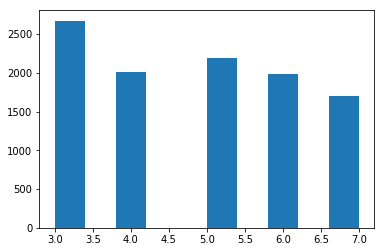

In [45]:
# digitize
bins = np.array([0.0, 1e-10000000, 2e-7, 2e-4,5e-4, 7e-4, 15e-4, ])
y_discrete= np.digitize(data.y.numpy(), bins)
print(y_discrete)
plt.hist(y_discrete)

In [46]:
y_discrete = y_discrete.flatten()

In [47]:
list(set(list(y_discrete.tolist())))

# so 5 classes

[3, 4, 5, 6, 7]

In [48]:
y_list = y_discrete.tolist()
for j in range(len(y_list)):
    if y_list[j] == 3:
        y_list[j]=0
    elif y_list[j] == 4:
        y_list[j]=1
    elif y_list[j] == 5:
        y_list[j]=2
    elif y_list[j] == 6:
        y_list[j]=3
    elif y_list[j] == 7:
        y_list[j]=4
    elif y_list[j] == 8:
        y_list[j]=5
        
set(y_list)
y_discrete = np.array(y_list)

In [49]:
y_discrete

array([1, 1, 0, ..., 3, 0, 0])

In [50]:
list(set(list(y_discrete.tolist())))

# so 5 classes

[0, 1, 2, 3, 4]

In [51]:
dataset.num_features

1433

In [52]:
len(data.y)

10556

## 9. Improving MetaLayer Edge betweenness approximation

- play with train splits
- play with mlp num units

In [22]:
%load_ext autoreload
%autoreload 2
import torch
from torch.nn import *
from TFM_edge_betweenness_model import META1
from TFM_node_betweenness_training import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import os.path as osp

from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T


def get_planetoid_dataset(root,name, normalize_features=False, transform=None):
    #path = osp.join(osp.dirname(osp.realpath(__file__)), '..', 'data', name)
    dataset = Planetoid(root, name)

    if transform is not None and normalize_features:
        dataset.transform = T.Compose([T.NormalizeFeatures(), transform])
    elif normalize_features:
        dataset.transform = T.NormalizeFeatures()
    elif transform is not None:
        dataset.transform = transform

    return dataset

#dataset1 = TUDataset(root='temp/'+thename, name='REDDIT-BINARY')
dataset = get_planetoid_dataset(root='temp/planetoid',name='Cora', normalize_features=True)
#inspectGraphDataset(dataset, thename)

In [25]:
# get dataset, see data.y is classess
data = dataset[0]
#data.y

# transform to nx
#g = pyTorchGeometricDatasetToNx(data)
g = pytorch_geometric_dataset_to_Nx2(data)

# compute node betweenness
eb = nx.edge_betweenness_centrality(g,normalized=True)

In [26]:
# match edge_index with index of eb
from pprint import pprint
data.edge_attr = torch.zeros(len(data.edge_index[0]),1)
#pprint(data.edge_attr)
data.y = torch.ones(len(data.edge_index[0]),1)
for j in range(len(data.edge_index[0])):
    t = (data.edge_index[0][j].item(), data.edge_index[1][j].item()) 
    t2 = (data.edge_index[1][j].item(), data.edge_index[0][j].item())
        
    if t in eb.keys():
        #print(t, eb[t])
        data.y[j]=eb[t]
        
    elif t2 in eb.keys():
        #print(t2, eb[t2])
        data.y[j]=eb[t2]
    else:
        # if edge was redundant it may not be captured by nx
        # but since it appeared in the original dataset we add it with value 0
        eb[t]=0.0
        #print(t, eb[t])
        data.y[j]=eb[t]
        
    #print(t,t2,data.edge_attr[j])
    #print(data.y[j])
    #print()
    
data.y = data.y.reshape(-1,1)
data.x = data.x.reshape(-1,1)

In [27]:
data.y = data.y.float()
data.y = torch.FloatTensor(data.y)
#data.y = data.y.reshape(-1,1)
data.y

tensor([[2.7029e-04],
        [2.6959e-04],
        [1.3978e-04],
        ...,
        [8.4398e-04],
        [2.7283e-07],
        [1.6845e-04]])

In [28]:
data.edge_attr = data.edge_attr.float()

[[4]
 [4]
 [3]
 ...
 [6]
 [3]
 [3]]


(array([2672.,    0., 2008.,    0.,    0., 2190.,    0., 1988.,    0.,
        1698.]),
 array([3. , 3.4, 3.8, 4.2, 4.6, 5. , 5.4, 5.8, 6.2, 6.6, 7. ]),
 <a list of 10 Patch objects>)

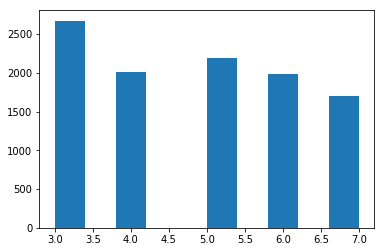

In [30]:
# digitize
bins = np.array([0.0, 1e-10000000, 2e-7, 2e-4,5e-4, 7e-4, 15e-4, ])
y_discrete= np.digitize(data.y.numpy(), bins)
print(y_discrete)
plt.hist(y_discrete)

In [31]:
y_discrete = y_discrete.flatten()

In [32]:
list(set(list(y_discrete.tolist())))

# so 5 classes

[3, 4, 5, 6, 7]

In [33]:
y_list = y_discrete.tolist()
for j in range(len(y_list)):
    if y_list[j] == 3:
        y_list[j]=0
    elif y_list[j] == 4:
        y_list[j]=1
    elif y_list[j] == 5:
        y_list[j]=2
    elif y_list[j] == 6:
        y_list[j]=3
    elif y_list[j] == 7:
        y_list[j]=4
    elif y_list[j] == 8:
        y_list[j]=5
        
set(y_list)
y_discrete = np.array(y_list)

In [34]:
y_discrete

array([1, 1, 0, ..., 3, 0, 0])

In [35]:
list(set(list(y_discrete.tolist())))

# so 5 classes

[0, 1, 2, 3, 4]

In [36]:
dataset.num_features

1433

In [37]:
len(data.y)

10556

In [53]:
from __future__ import division

import time
from pprint import pprint

import torch
import torch.nn.functional as F
from torch import tensor
from torch.optim import Adam

from torch_geometric.nn import SGConv, APPNP, ChebConv, GATConv

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.uint8, device=index.device)
    mask[index] = 1
    return mask


def random_planetoid_splits(data, y, num_classes):
    # Set new random planetoid splits:
    # * 20 * num_classes labels for training
    # * 500 labels for validation
    # * 1000 labels for testing
    

    #indices = []
    #for i in range(num_classes):
    #    index = (data.y == i).nonzero().view(-1)
    #    index = index[torch.randperm(index.size(0))]
    #    indices.append(index)
    ## changed 20 -> 40, 500->750 
    #train_index = torch.cat([i[:300] for i in indices], dim=0)

    #rest_index = torch.cat([i[300:] for i in indices], dim=0)
    #rest_index = rest_index[torch.randperm(rest_index.size(0))]

    #data.train_mask = index_to_mask(train_index, size=data.num_nodes)
    #data.val_mask = index_to_mask(rest_index[:4000], size=data.num_nodes)
    #data.test_mask = index_to_mask(rest_index[4000:], size=data.num_nodes)
    
    # they should be correspondent, so train_edge_mask & co should be derived...
    # too lazy , just remove mask for nodes for now
    
    indices = []
    for i in range(num_classes):
        index = (y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)
    # changed 20 -> 40, 500->750 
    train_index = torch.cat([i[:300] for i in indices], dim=0)

    rest_index = torch.cat([i[300:] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]
    
    data.train_edge_mask = index_to_mask(train_index, size=len(y))
    data.val_edge_mask = index_to_mask(rest_index[:4000], size=len(y))
    data.test_edge_mask = index_to_mask(rest_index[4000:], size=len(y))

    return data


def run(dataset,
        y,
        num_classes,
        model,
        runs,
        epochs,
        lr,
        weight_decay,
        early_stopping,
        permute_masks=None,
        logger=None):

    val_losses, accs, durations = [], [], []
    for _ in range(runs):
        data = dataset[0]
        if permute_masks is not None:
            data = permute_masks(data,y, num_classes)
        data = data.to(device)
        y = y.to(device)

        model.to(device).reset_parameters()
        optimizer = Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_start = time.perf_counter()

        best_val_loss = float('inf')
        test_acc = 0
        val_loss_history = []

        for epoch in range(1, epochs + 1):
            train(model, optimizer, data, y)
            eval_info = evaluate(model, data, y)
            eval_info['epoch'] = epoch

            if logger is not None:
                logger(eval_info)

            if eval_info['val_loss'] < best_val_loss:
                best_val_loss = eval_info['val_loss']
                test_acc = eval_info['test_acc']

            val_loss_history.append(eval_info['val_loss'])
            if early_stopping > 0 and epoch > epochs // 2:
                tmp = tensor(val_loss_history[-(early_stopping + 1):-1])
                if eval_info['val_loss'] > tmp.mean().item():
                    break

        if torch.cuda.is_available():
            torch.cuda.synchronize()

        t_end = time.perf_counter()

        val_losses.append(best_val_loss)
        accs.append(test_acc)
        durations.append(t_end - t_start)
        
        

    loss, acc, duration = tensor(val_losses), tensor(accs), tensor(durations)

    print('Val Loss: {:.4f}, Test Accuracy: {:.3f} ± {:.3f}, Duration: {:.3f}'.
          format(loss.mean().item(),
                 acc.mean().item(),
                 acc.std().item(),
                 duration.mean().item()))
    with open('preliminary_semisuperv.csv','a') as f:
        if 'conv1' in dir(model):
            f.write('{}, {}, {:.4f}, {:.3f} ± {:.3f}, {:.3f}\n'.
              format(
                     model.conv1.__class__.__name__, 
                     str(runs)+'_epochs='+str(epochs),
                     loss.mean().item(),
                     acc.mean().item(),
                     acc.std().item(),
                     duration.mean().item()))
        else:
            f.write('{}, {}, {:.4f}, {:.3f} ± {:.3f}, {:.3f}\n'.
              format(
                     model.__class__.__name__, 
                     str(runs)+'_epochs='+str(epochs),
                     loss.mean().item(),
                     acc.mean().item(),
                     acc.std().item(),
                     duration.mean().item()))
            
            
    return model.to('cpu')
            

def train(model, optimizer, data, y):
    model.train()
    optimizer.zero_grad()
    # so the model uses all the nodes and edges
    out = model(data)
    # but only tests loss on masked edges...
    loss = F.nll_loss(out[data.train_edge_mask], y[data.train_edge_mask])
    loss.backward()
    optimizer.step()


def evaluate(model, data, y):
    model.eval()

    with torch.no_grad():
        logits = model(data)

    outs = {}
    for key in ['train', 'val', 'test']:
        mask = data['{}_mask'.format(key)]
        edge_mask = data['{}_edge_mask'.format(key)]
        loss = F.nll_loss(logits[edge_mask], y[edge_mask]).item()
        pred = logits[edge_mask].max(1)[1]
        acc = pred.eq(y[edge_mask]).sum().item() / edge_mask.sum().item()

        outs['{}_loss'.format(key)] = loss
        outs['{}_acc'.format(key)] = acc

    return outs

In [42]:
import warnings
warnings.filterwarnings('ignore')

[[4]
 [4]
 [3]
 ...
 [6]
 [3]
 [3]]
num_classes= 5 
 [0, 1, 2, 3, 4]
Val Loss: 1.2039, Test Accuracy: 0.530 ± 0.062, Duration: 0.369


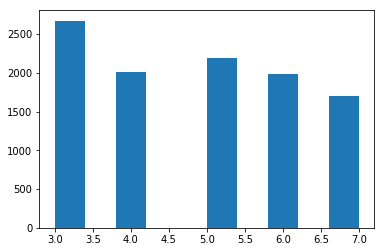

In [48]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
#from torch_geometric.nn import LinkGCNConv
from torch_geometric.nn import SAGEConv
import torch.nn as nn

from torch_geometric.data import DataLoader
from torch_geometric.data import InMemoryDataset
import importlib
from torch_geometric.data import Data


from torch.nn import Sequential as Seq, Linear as Lin, ReLU
from torch_scatter import scatter_mean
from torch_geometric.nn import MetaLayer

from TFM_node_betweenness_training import *

class EdgeModel(torch.nn.Module):
    def __init__(self,num_edge_features, num_features, num_edges):
        super(EdgeModel, self).__init__()
        #self.edge_mlp = Seq(Lin(2 * 10 + 5 + 20, 5), ReLU(), Lin(5, 5))
        self.edge_mlp = Seq(Lin(2*num_features + num_edge_features +1 ,10), ReLU(), Lin(10, 19))

    def forward(self, src, dest, edge_attr, u, batch):
        # source, target: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        #print(src.shape, dest.shape, edge_attr.shape, u[batch].shape)
        out = torch.cat([src, dest, edge_attr, u[batch]], 1)
        return self.edge_mlp(out)

class NodeModel(torch.nn.Module):
    def __init__(self,num_edge_features, num_features, num_edges):
        super(NodeModel, self).__init__()
        #self.node_mlp_1 = Seq(Lin(15, 10), ReLU(), Lin(10, 10))
        edgemodel_output_size=19
        self.node_mlp_1 = Seq(Lin(num_features+edgemodel_output_size, 10), ReLU(), Lin(10, 16))
        #self.node_mlp_2 = Seq(Lin(2 * 10 + 20, 10), ReLU(), Lin(10, 10))
        self.node_mlp_2 = Seq(Lin(num_features+1+16, 10), ReLU(), Lin(10, 15))


    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out, u[batch]], dim=1)
        return self.node_mlp_2(out)

class GlobalModel(torch.nn.Module):
    def __init__(self):
        super(GlobalModel, self).__init__()
        self.global_mlp = Seq(Lin(20 + 10, 20), ReLU(), Lin(20, 20))

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        out = torch.cat([u, scatter_mean(x, batch, dim=0)], dim=1)
        #return self.global_mlp(out)
        return u


class META1(torch.nn.Module):
    def __init__(self, 
                 num_classes=5, 
                 num_edge_features=1, 
                 num_features=1433, 
                 edge_attr=None, 
                 d4 =19,d5=16,
                 num_edges=6):
        super(META1, self).__init__()

        self.op = MetaLayer(
            EdgeModel(num_edge_features,num_features, num_edges), 
            NodeModel(num_edge_features, num_features, num_edges),  
            GlobalModel())
        self.fc1 = nn.Linear(d4, d5)
        self.dense1_bn = nn.BatchNorm1d(d5)
        self.fc2 = nn.Linear(d5, num_classes) 
        self.dense2_bn = nn.BatchNorm1d(num_classes)
        self.edge_attr = edge_attr.to(device)
        self.num_edges = num_edges
    
    def reset_parameters(self):
        self.op.reset_parameters()
        #self.conv2.reset_parameters()

    def forward(self, data):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        x, edge_index, edge_attr,  batch = data.x, data.edge_index, self.edge_attr,  torch.tensor([0] * len(data.x))        
        #batch must say for each row, which graph it belongs to
        # since only one graph is trained here -> all 0s with length of data.x

        x2, edge_attr2, u2 =  self.op(x, edge_index, edge_attr, torch.ones(1,1).to(device), batch.to(device))
        #x = torch.cat([x2,edge_attr2])
        x = edge_attr2
        #print("after metalayer",x.shape)

        x = F.relu(self.dense1_bn(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) 

data, y_discrete, num_features, num_classes, num_edges, num_edge_features = dataset_preprocessing(
    dataset[0], 
    num_features=dataset.num_features)
permute_masks = random_planetoid_splits 
num_features = 1
num_classes = 5
run(dataset,
    y_discrete, 
    num_classes, 
    META1( 
        num_classes=num_classes,
        num_edge_features=1, # for eache edge only 1 feature
        num_features=dataset.num_features, 
        edge_attr = torch.FloatTensor(data.edge_attr), 
        num_edges=len(data.edge_attr),
    ), 
    100, # runs 
    20, # epochs
    0.01,  # lr
    0.0005, #wd
    10, permute_masks)

# need to change train,val, mask to edges instead of nodes!


In [50]:
run(dataset,
    y_discrete, 
    num_classes, 
    META1( 
        num_classes=num_classes,
        num_edge_features=1, # for eache edge only 1 feature
        num_features=dataset.num_features, 
        edge_attr = torch.FloatTensor(data.edge_attr), 
        num_edges=len(data.edge_attr),
    ), 
    100, # runs 
    200, # epochs
    0.01,  # lr
    0.0005, #wd
    10, permute_masks)

Val Loss: 2.1925, Test Accuracy: 0.411 ± 0.036, Duration: 3.421


In [52]:

class EdgeModel(torch.nn.Module):
    def __init__(self,num_edge_features, num_features, num_edges):
        super(EdgeModel, self).__init__()
        #self.edge_mlp = Seq(Lin(2 * 10 + 5 + 20, 5), ReLU(), Lin(5, 5))
        self.edge_mlp = Seq(Lin(2*num_features + num_edge_features +1 ,10), ReLU(), Lin(10, 10))

    def forward(self, src, dest, edge_attr, u, batch):
        # source, target: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.
        #print(src.shape, dest.shape, edge_attr.shape, u[batch].shape)
        out = torch.cat([src, dest, edge_attr, u[batch]], 1)
        return self.edge_mlp(out)

class NodeModel(torch.nn.Module):
    def __init__(self,num_edge_features, num_features, num_edges):
        super(NodeModel, self).__init__()
        #self.node_mlp_1 = Seq(Lin(15, 10), ReLU(), Lin(10, 10))
        edgemodel_output_size=10
        self.node_mlp_1 = Seq(Lin(num_features+edgemodel_output_size, 10), ReLU(), Lin(10, 10))
        #self.node_mlp_2 = Seq(Lin(2 * 10 + 20, 10), ReLU(), Lin(10, 10))
        self.node_mlp_2 = Seq(Lin(num_features+1+10, 10), ReLU(), Lin(10, 10))


    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out, u[batch]], dim=1)
        return self.node_mlp_2(out)

class GlobalModel(torch.nn.Module):
    def __init__(self):
        super(GlobalModel, self).__init__()
        self.global_mlp = Seq(Lin(20 + 10, 20), ReLU(), Lin(20, 10))

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        out = torch.cat([u, scatter_mean(x, batch, dim=0)], dim=1)
        #return self.global_mlp(out)
        return u


class META2(torch.nn.Module):
    def __init__(self, 
                 num_classes=5, 
                 num_edge_features=1, 
                 num_features=1433, 
                 edge_attr=None, 
                 d4 =10,d5=10,
                 num_edges=6):
        super(META2, self).__init__()

        self.op = MetaLayer(
            EdgeModel(num_edge_features,num_features, num_edges), 
            NodeModel(num_edge_features, num_features, num_edges),  
            GlobalModel())
        self.fc1 = nn.Linear(d4, d5)
        self.dense1_bn = nn.BatchNorm1d(d5)
        self.fc2 = nn.Linear(d5, num_classes) 
        self.dense2_bn = nn.BatchNorm1d(num_classes)
        self.edge_attr = edge_attr.to(device)
        self.num_edges = num_edges
    
    def reset_parameters(self):
        self.op.reset_parameters()
        #self.conv2.reset_parameters()

    def forward(self, data):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        x, edge_index, edge_attr,  batch = data.x, data.edge_index, self.edge_attr,  torch.tensor([0] * len(data.x))        
        #batch must say for each row, which graph it belongs to
        # since only one graph is trained here -> all 0s with length of data.x

        x2, edge_attr2, u2 =  self.op(x, edge_index, edge_attr, torch.ones(1,1).to(device), batch.to(device))
        #x = torch.cat([x2,edge_attr2])
        x = edge_attr2
        #print("after metalayer",x.shape)

        x = F.relu(self.dense1_bn(self.fc1(x)))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) 

run(dataset,
    y_discrete, 
    num_classes, 
    META2( 
        num_classes=num_classes,
        num_edge_features=1, # for eache edge only 1 feature
        num_features=dataset.num_features, 
        edge_attr = torch.FloatTensor(data.edge_attr), 
        num_edges=len(data.edge_attr),
    ), 
    100, # runs 
    20, # epochs
    0.01,  # lr
    0.0005, #wd
    10, permute_masks)
# probabli using hidden_units > 10 values

Val Loss: 1.1372, Test Accuracy: 0.553 ± 0.077, Duration: 0.404


In [54]:
model = run(dataset,
    y_discrete, 
    num_classes, 
    META2( 
        num_classes=num_classes,
        num_edge_features=1, # for eache edge only 1 feature
        num_features=dataset.num_features, 
        edge_attr = torch.FloatTensor(data.edge_attr), 
        num_edges=len(data.edge_attr),
    ), 
    100, # runs 
    20, # epochs
    0.01,  # lr
    0.0005, #wd
    10, permute_masks)
# last value hidden_units used = 10

Val Loss: 1.0746, Test Accuracy: 0.582 ± 0.065, Duration: 0.361


## 3. Inductive setting quick test

Test trained model on another graph!

In [2]:
%load_ext autoreload
%autoreload 2
import torch
from torch.nn import *
from TFM_edge_betweenness_model import META1
from TFM_node_betweenness_training import *
import os.path as osp

from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

In [16]:
class MyOwnDataset2():
    def __init__(self,  root, name, transform=None, pre_transform=None):
        f = open(name, 'rb')
        self.data = pickle.load(f) 
        #print(self.data.num_features)
        self.num_features = self.data.num_features
        self.num_classes = 1
        f.close()
        

        
dname='../datasets/precomputed-pytorchg-betweenness_old/KarateClub_1_nd.pickle'
dataset2 = loadDataset(
        collection='MyOwnDataset2', 
        name=dname)



In [17]:
dir(dataset2.data)

['__call__',
 '__cat_dim__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__inc__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'apply',
 'clone',
 'coalesce',
 'contains_isolated_nodes',
 'contains_self_loops',
 'contiguous',
 'debug',
 'edge_attr',
 'edge_index',
 'from_dict',
 'is_coalesced',
 'is_directed',
 'is_undirected',
 'keys',
 'num_edge_features',
 'num_edges',
 'num_faces',
 'num_features',
 'num_node_features',
 'num_nodes',
 'pos',
 'to',
 'x',
 'y']

In [18]:
print(dataset2.data.y.shape)
print(dataset2.data.x.shape)

torch.Size([34])
torch.Size([34, 1])


In [19]:
     
def index_to_mask(index, size):
    mask = torch.zeros(size, dtype=torch.uint8, device=index.device)
    mask[index] = 1
    return mask

In [20]:
def random_karate_splits(data, y, num_classes):
    indices = []
    for i in range(num_classes):
        index = (y == i).nonzero().view(-1)
        index = index[torch.randperm(index.size(0))]
        indices.append(index)
    # changed 20 -> 40, 500->750 
    train_index = torch.cat([i[:2] for i in indices], dim=0)

    rest_index = torch.cat([i[2:] for i in indices], dim=0)
    rest_index = rest_index[torch.randperm(rest_index.size(0))]
    
    data.train_edge_mask = index_to_mask(train_index, size=len(y))
    data.val_edge_mask = index_to_mask(rest_index[:7], size=len(y))
    data.test_edge_mask = index_to_mask(rest_index[7:], size=len(y))

    return data
        

[[3]
 [3]
 [5]
 [5]
 [2]
 [2]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [2]
 [2]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [5]
 [4]
 [4]
 [5]
 [5]
 [4]
 [4]
 [5]
 [5]
 [3]
 [3]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [2]
 [4]
 [4]
 [2]
 [2]
 [3]
 [3]
 [1]
 [1]
 [4]
 [4]
 [1]
 [1]
 [4]
 [4]
 [2]
 [2]
 [5]
 [5]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [3]
 [3]
 [3]
 [3]
 [1]
 [1]
 [4]
 [4]
 [4]
 [4]
 [5]
 [5]
 [5]
 [5]
 [4]
 [4]
 [5]
 [5]
 [2]
 [2]
 [4]
 [4]
 [5]
 [5]
 [2]
 [2]
 [3]
 [3]
 [3]
 [3]
 [2]
 [2]
 [2]
 [2]
 [4]
 [4]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [3]
 [2]
 [2]
 [3]
 [3]
 [1]
 [1]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [4]
 [5]
 [5]
 [3]
 [3]
 [2]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
num_classes= 3 
 [0, 1, 2]


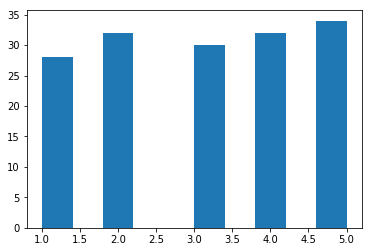

In [24]:
data2, y_discrete2, num_features2, num_classes2, num_edges2, num_edge_features2 = dataset_preprocessing(
    dataset2.data,
    thebins= [0.0,0.010,0.023,0.030, 0.0415],
    num_features=dataset2.num_features
)
permute_masks = random_karate_splits 
num_features = 1
num_classes = 5

In [25]:
data2

Data(edge_attr=[156, 1], edge_index=[2, 156], x=[34, 1], y=[156, 1])

In [26]:
def evaluate(model, data, y):
    
    
    model=model.to(device)
    data = data.to(device)
    y= y.to(device)
    model.eval()

    with torch.no_grad():
        logits = model(data)

    outs = {}
    for key in ['train', 'val', 'test']:
        mask = data['{}_mask'.format(key)]
        edge_mask = data['{}_edge_mask'.format(key)]
        loss = F.nll_loss(logits[edge_mask], y[edge_mask]).item()
        pred = logits[edge_mask].max(1)[1]
        acc = pred.eq(y[edge_mask]).sum().item() / edge_mask.sum().item()

        outs['{}_loss'.format(key)] = loss
        outs['{}_acc'.format(key)] = acc

    return outs

outs = evaluate(model,data2,y_discrete2)

NameError: name 'model' is not defined

In [13]:
dir(data2)

NameError: name 'data2' is not defined